# Load libraries

In [1]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib scikit-learn seaborn umap-learn scipy xgboost shap PyALE


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps  # Ensure this is imported
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import seaborn as sns
import math
import json
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, r2_score
import shap
from PyALE import ale
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import linregress, spearmanr

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Loading the data

In [82]:
chamau_lag = pd.read_csv("../datasets/Chamau_2014-2024_clean_newlag.csv")
chamau_daily = pd.read_csv("../datasets/Chamau_Daily_2014-2024_newlag.csv")
oensingen_1_lag = pd.read_csv("../datasets/Oensingen_2018-19_clean_newlag.csv")
oensingen_1_daily = pd.read_csv("../datasets/Oensingen_Daily_2018-19_newlag.csv")
oensingen_2_lag = pd.read_csv("../datasets/Oensingen_2021-23_clean_newlag.csv")
oensingen_2_daily = pd.read_csv("../datasets/Oensingen_Daily_2021-23_newlag.csv")
aeschi_lag = pd.read_csv("../datasets/Aeschi_2019-20_clean_newlag.csv")
aeschi_daily = pd.read_csv("../datasets/Aeschi_Daily_2019-20_newlag.csv")
forel_lag = pd.read_csv("../datasets/Forel_2024-25_clean_newlag.csv")
forel_daily = pd.read_csv("../datasets/Forel_Daily_2024-25_newlag.csv")
tanikon_lag = pd.read_csv("../datasets/Tanikon_2023-25_clean_newlag.csv")
tanikon_daily = pd.read_csv("../datasets/Tanikon_Daily_2023-25_newlag.csv")

# Experiment 1: Oensingen 2018-19

In [68]:
# FIX TIMESTAMP
oensingen_1_lag['Timestamp'] = pd.to_datetime(oensingen_1_lag['Timestamp'])
oensingen_1_lag = oensingen_1_lag.set_index('Timestamp').sort_index()

oensingen_1_daily['Date'] = pd.to_datetime(oensingen_1_daily['Date'])
oensingen_1_daily = oensingen_1_daily.sort_values('Date')

In [64]:
def train_xgb_timeseries(df, predictors, target, test_size=0.1, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    
    Now includes a time series comparison plot showing observed vs predicted values over time.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    # Store test dates for time series plot
    test_dates = X_test.index
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        # Create 3-subplot figure: scatter, feature importance, and TIME SERIES
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.3f}, ρ={rho:.3f})")
        axes[0].grid(True, alpha=0.3)
        
        # 2. Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        # 3. TIME SERIES COMPARISON (NEW!)
        axes[2].plot(test_dates, y_test_lin.values, label="Observed", color="black", lw=1.5)
        axes[2].plot(test_dates, y_pred_lin, label="Predicted", color="royalblue", lw=1.5, alpha=0.8)
        axes[2].set_xlabel("Date")
        axes[2].set_ylabel("N₂O Flux")
        axes[2].set_title("Time Series Comparison")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
        "test_dates": test_dates,  # Also return test dates
    }

EXPERIMENT 1: Oensingen 2018-2019

--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 2018-07-12 07:45:00 → 2018-09-23 19:45:00
Test  period: 2018-09-23 21:45:00 → 2019-10-04 23:15:00

Model evaluation:
  R² (linear scale): -0.759
  Spearman ρ:        0.303


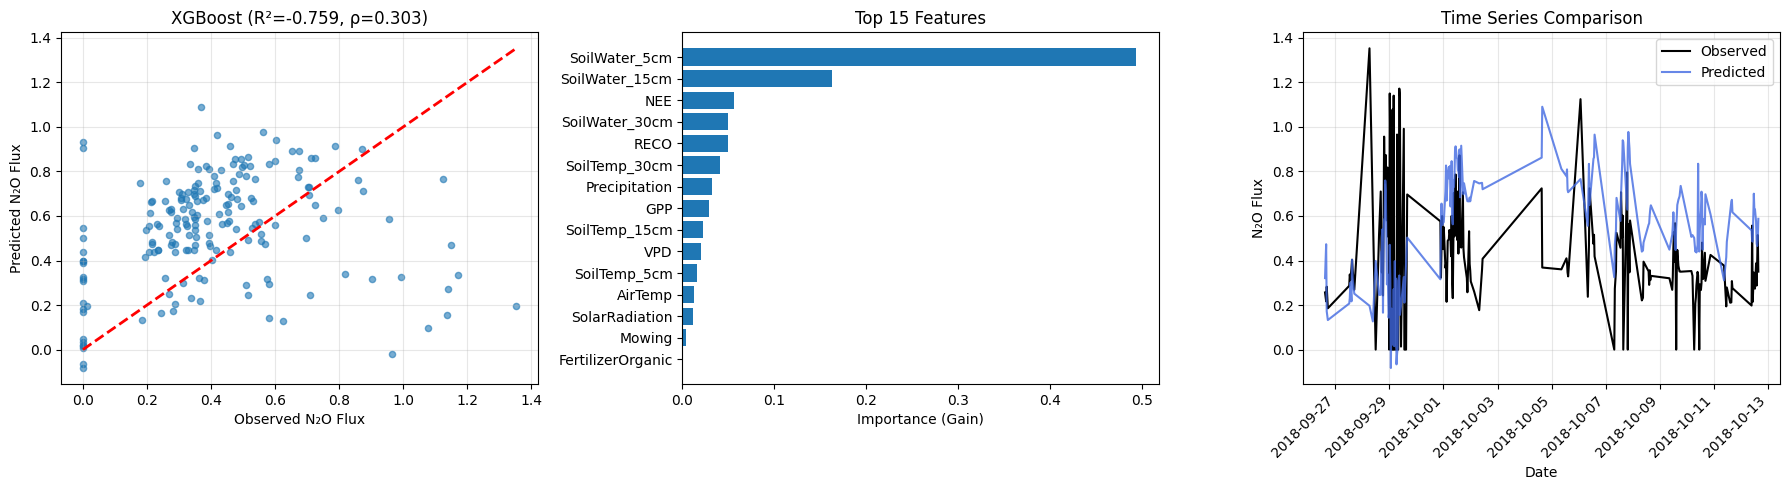


--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 2018-07-12 07:45:00 → 2018-09-07 06:15:00
Test  period: 2018-09-07 06:45:00 → 2019-10-04 23:15:00

Model evaluation:
  R² (linear scale): -1.468
  Spearman ρ:        0.383


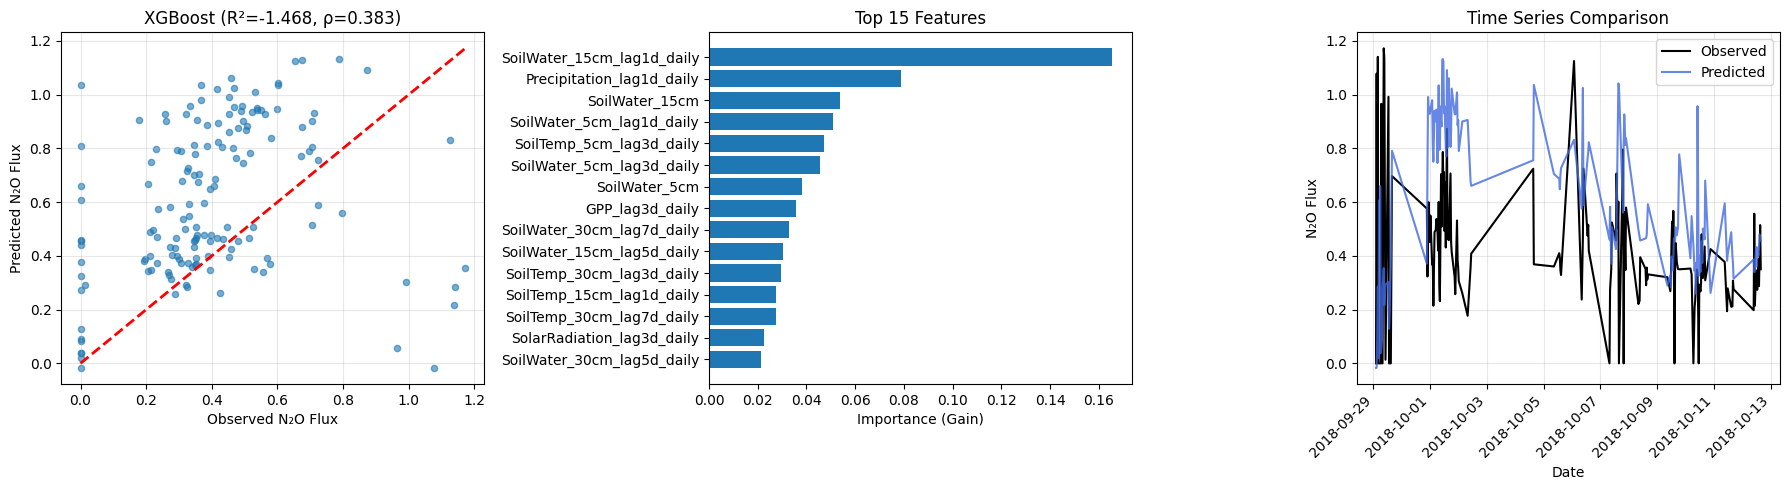


--- HOURLY | target=N2O_Flux_ln | predictors=AUGMENTED ---
Train period: 2018-07-12 07:45:00 → 2018-09-07 06:15:00
Test  period: 2018-09-07 06:45:00 → 2019-10-04 23:15:00

Model evaluation:
  R² (linear scale): -0.914
  Spearman ρ:        0.339


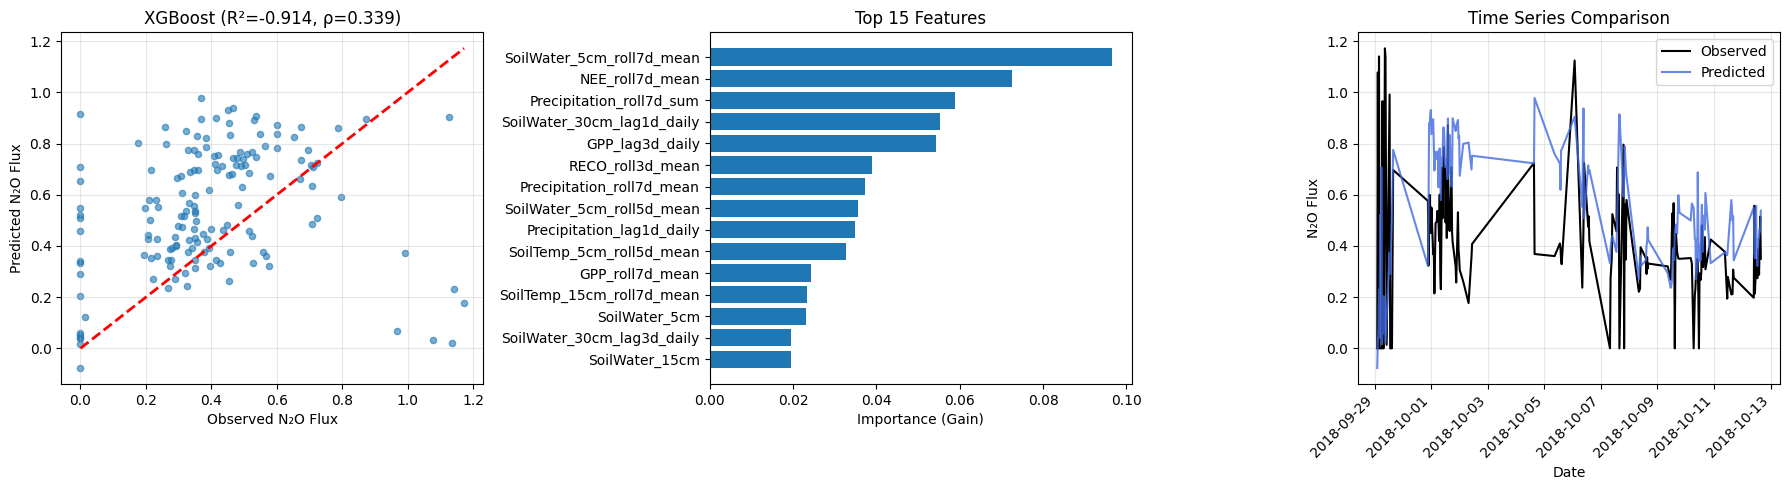


--- DAILY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 0 → 79
Test  period: 80 → 164

Model evaluation:
  R² (linear scale): -12.612
  Spearman ρ:        0.700


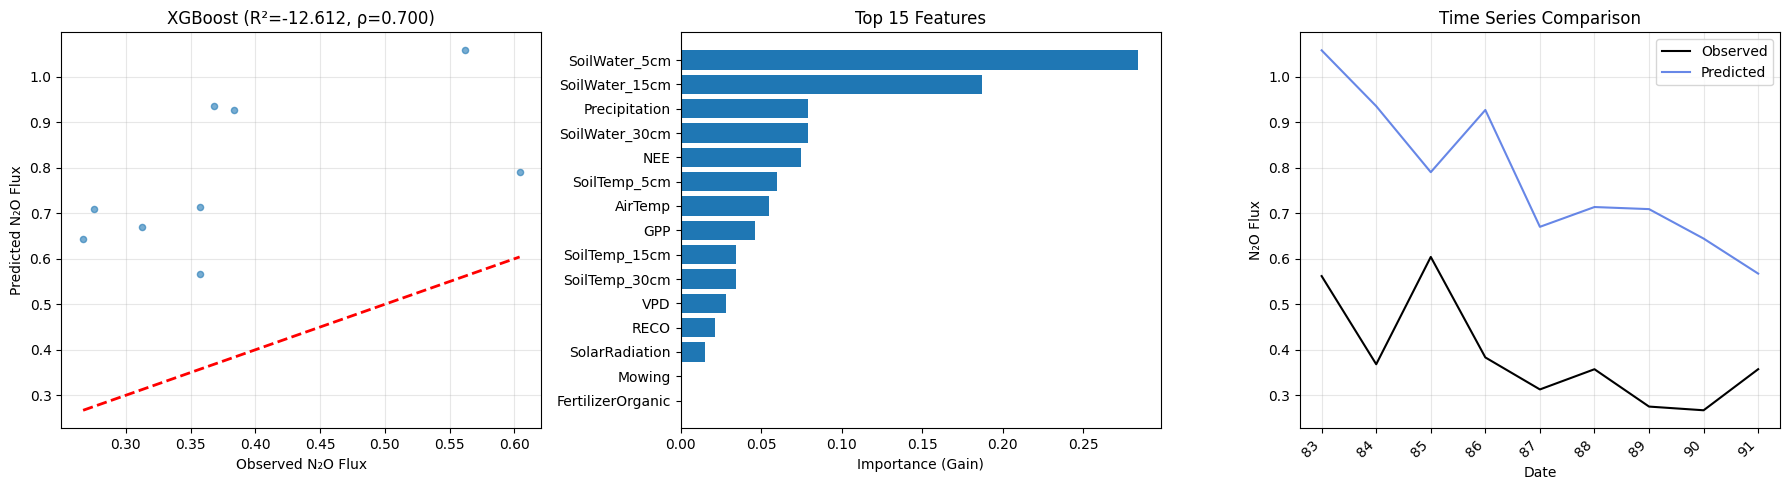


--- DAILY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 0 → 66
Test  period: 67 → 164

Model evaluation:
  R² (linear scale): -6.117
  Spearman ρ:        -0.071


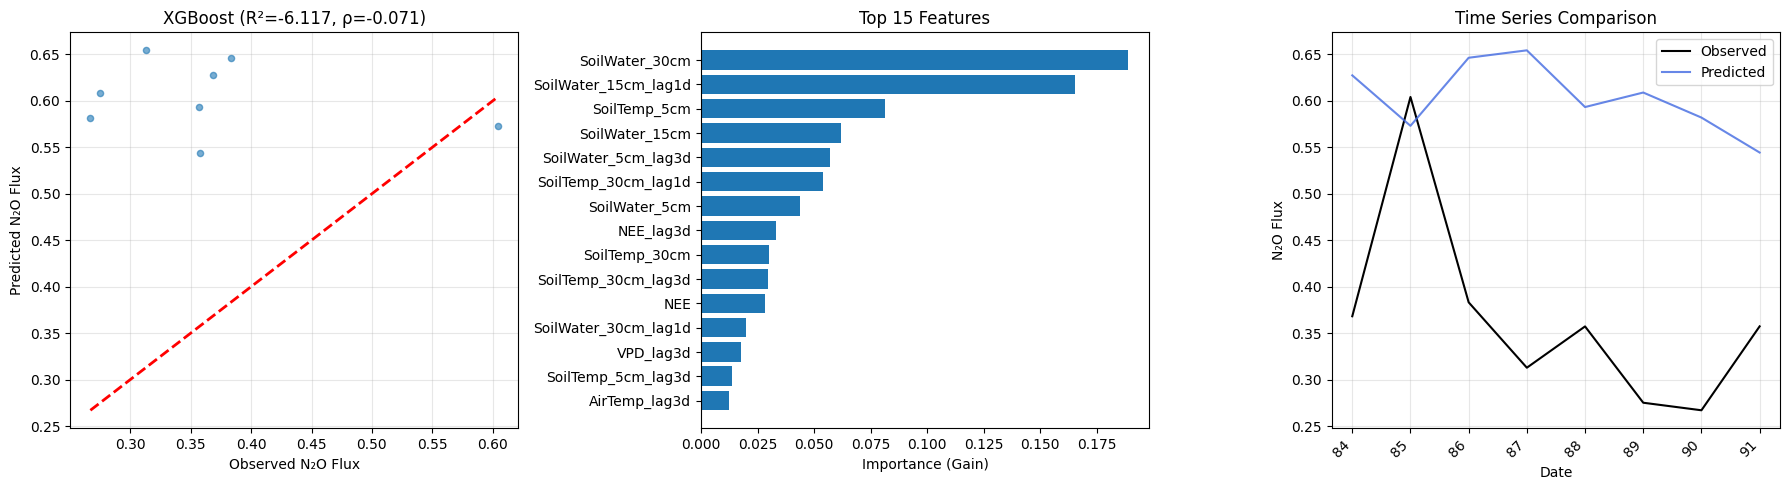


--- DAILY | target=N2O_Flux_ln | predictors=AUGMENTED ---
Train period: 0 → 66
Test  period: 67 → 164

Model evaluation:
  R² (linear scale): -1.739
  Spearman ρ:        0.167


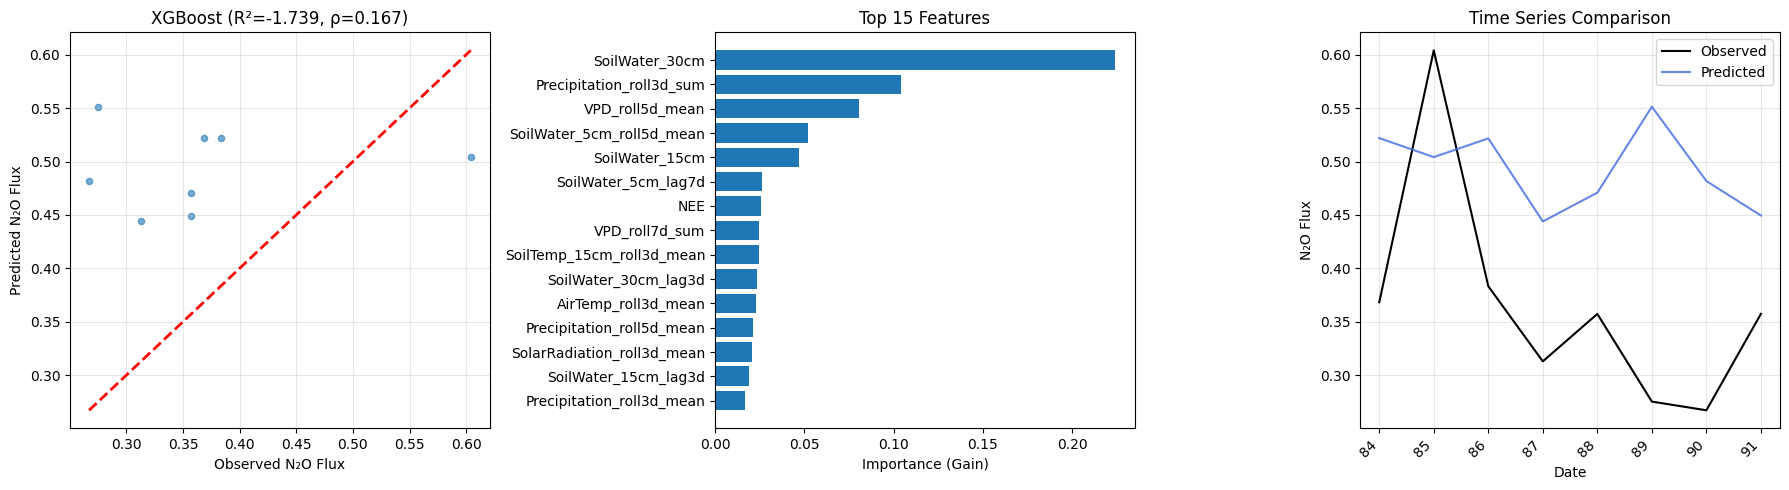


COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:
Temporal     Predictors   R²       Spearman ρ  
--------------------------------------------------------------------------------
Hourly       Base         -0.759        0.303
Hourly       Lag          -1.468        0.383
Hourly       Augmented    -0.914        0.339
Daily        Base         -12.612        0.700
Daily        Lag          -6.117       -0.071
Daily        Augmented    -1.739        0.167

IMPROVEMENT FROM BASE TO LAG:
Hourly: R² + -0.709, ρ +  0.080
Daily:  R² +  6.495, ρ + -0.771

IMPROVEMENT FROM LAG TO AUGMENTED:
Hourly: R² +  0.554, ρ + -0.044
Daily:  R² +  4.378, ρ +  0.238


In [65]:
# ============================================================================
# OENSINGEN 1
# ============================================================================

print("="*80)
print("EXPERIMENT 1: Oensingen 2018-2019")
print("="*80)

# Define base and lag predictors
base_predictors = [
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
]

hourly_lag_predictors = [
    # --- Meteorological base variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",

    # --- Meteorological lag variables ---
    "NEE_lag1d_daily", "NEE_lag3d_daily", "NEE_lag5d_daily", "NEE_lag7d_daily",
    "GPP_lag1d_daily", "GPP_lag3d_daily", "GPP_lag5d_daily", "GPP_lag7d_daily",
    "RECO_lag1d_daily", "RECO_lag3d_daily", "RECO_lag5d_daily", "RECO_lag7d_daily",
    "SolarRadiation_lag1d_daily", "SolarRadiation_lag3d_daily", "SolarRadiation_lag5d_daily", "SolarRadiation_lag7d_daily",
    "AirTemp_lag1d_daily", "AirTemp_lag3d_daily", "AirTemp_lag5d_daily", "AirTemp_lag7d_daily",
    "VPD_lag1d_daily", "VPD_lag3d_daily", "VPD_lag5d_daily", "VPD_lag7d_daily",
    "SoilWater_5cm_lag1d_daily", "SoilWater_5cm_lag3d_daily", "SoilWater_5cm_lag5d_daily", "SoilWater_5cm_lag7d_daily",
    "SoilWater_15cm_lag1d_daily", "SoilWater_15cm_lag3d_daily", "SoilWater_15cm_lag5d_daily", "SoilWater_15cm_lag7d_daily",
    "SoilWater_30cm_lag1d_daily", "SoilWater_30cm_lag3d_daily", "SoilWater_30cm_lag5d_daily", "SoilWater_30cm_lag7d_daily",
    "SoilTemp_5cm_lag1d_daily", "SoilTemp_5cm_lag3d_daily", "SoilTemp_5cm_lag5d_daily", "SoilTemp_5cm_lag7d_daily",
    "SoilTemp_15cm_lag1d_daily", "SoilTemp_15cm_lag3d_daily", "SoilTemp_15cm_lag5d_daily", "SoilTemp_15cm_lag7d_daily",
    "SoilTemp_30cm_lag1d_daily", "SoilTemp_30cm_lag3d_daily", "SoilTemp_30cm_lag5d_daily", "SoilTemp_30cm_lag7d_daily",
    "Precipitation_lag1d_daily", "Precipitation_lag3d_daily", "Precipitation_lag5d_daily", "Precipitation_lag7d_daily",

    # --- Management variables ---
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_SoilCultivation"
]

hourly_augmented_predictors = [
    # --- Base current-day variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",
    
    # --- Lag features (1, 3, 5, 7 days) ---
    "NEE_lag1d_daily", "NEE_lag3d_daily", "NEE_lag5d_daily", "NEE_lag7d_daily",
    "GPP_lag1d_daily", "GPP_lag3d_daily", "GPP_lag5d_daily", "GPP_lag7d_daily",
    "RECO_lag1d_daily", "RECO_lag3d_daily", "RECO_lag5d_daily", "RECO_lag7d_daily",
    "SolarRadiation_lag1d_daily", "SolarRadiation_lag3d_daily", "SolarRadiation_lag5d_daily", "SolarRadiation_lag7d_daily",
    "AirTemp_lag1d_daily", "AirTemp_lag3d_daily", "AirTemp_lag5d_daily", "AirTemp_lag7d_daily",
    "VPD_lag1d_daily", "VPD_lag3d_daily", "VPD_lag5d_daily", "VPD_lag7d_daily",
    "SoilWater_5cm_lag1d_daily", "SoilWater_5cm_lag3d_daily", "SoilWater_5cm_lag5d_daily", "SoilWater_5cm_lag7d_daily",
    "SoilWater_15cm_lag1d_daily", "SoilWater_15cm_lag3d_daily", "SoilWater_15cm_lag5d_daily", "SoilWater_15cm_lag7d_daily",
    "SoilWater_30cm_lag1d_daily", "SoilWater_30cm_lag3d_daily", "SoilWater_30cm_lag5d_daily", "SoilWater_30cm_lag7d_daily",
    "SoilTemp_5cm_lag1d_daily", "SoilTemp_5cm_lag3d_daily", "SoilTemp_5cm_lag5d_daily", "SoilTemp_5cm_lag7d_daily",
    "SoilTemp_15cm_lag1d_daily", "SoilTemp_15cm_lag3d_daily", "SoilTemp_15cm_lag5d_daily", "SoilTemp_15cm_lag7d_daily",
    "SoilTemp_30cm_lag1d_daily", "SoilTemp_30cm_lag3d_daily", "SoilTemp_30cm_lag5d_daily", "SoilTemp_30cm_lag7d_daily",
    "Precipitation_lag1d_daily", "Precipitation_lag3d_daily", "Precipitation_lag5d_daily", "Precipitation_lag7d_daily",
    
    # --- Rolling mean features (3, 5, 7 day windows) ---
    "NEE_roll3d_mean", "NEE_roll5d_mean", "NEE_roll7d_mean",
    "GPP_roll3d_mean", "GPP_roll5d_mean", "GPP_roll7d_mean",
    "RECO_roll3d_mean", "RECO_roll5d_mean", "RECO_roll7d_mean",
    "SolarRadiation_roll3d_mean", "SolarRadiation_roll5d_mean", "SolarRadiation_roll7d_mean",
    "AirTemp_roll3d_mean", "AirTemp_roll5d_mean", "AirTemp_roll7d_mean",
    "VPD_roll3d_mean", "VPD_roll5d_mean", "VPD_roll7d_mean",
    "SoilWater_5cm_roll3d_mean", "SoilWater_5cm_roll5d_mean", "SoilWater_5cm_roll7d_mean",
    "SoilWater_15cm_roll3d_mean", "SoilWater_15cm_roll5d_mean", "SoilWater_15cm_roll7d_mean",
    "SoilWater_30cm_roll3d_mean", "SoilWater_30cm_roll5d_mean", "SoilWater_30cm_roll7d_mean",
    "SoilTemp_5cm_roll3d_mean", "SoilTemp_5cm_roll5d_mean", "SoilTemp_5cm_roll7d_mean",
    "SoilTemp_15cm_roll3d_mean", "SoilTemp_15cm_roll5d_mean", "SoilTemp_15cm_roll7d_mean",
    "SoilTemp_30cm_roll3d_mean", "SoilTemp_30cm_roll5d_mean", "SoilTemp_30cm_roll7d_mean",
    "Precipitation_roll3d_mean", "Precipitation_roll5d_mean", "Precipitation_roll7d_mean",
    
    # --- Rolling sum features (3, 5, 7 day windows) ---
    "NEE_roll3d_sum", "NEE_roll5d_sum", "NEE_roll7d_sum",
    "GPP_roll3d_sum", "GPP_roll5d_sum", "GPP_roll7d_sum",
    "RECO_roll3d_sum", "RECO_roll5d_sum", "RECO_roll7d_sum",
    "SolarRadiation_roll3d_sum", "SolarRadiation_roll5d_sum", "SolarRadiation_roll7d_sum",
    "AirTemp_roll3d_sum", "AirTemp_roll5d_sum", "AirTemp_roll7d_sum",
    "VPD_roll3d_sum", "VPD_roll5d_sum", "VPD_roll7d_sum",
    "SoilWater_5cm_roll3d_sum", "SoilWater_5cm_roll5d_sum", "SoilWater_5cm_roll7d_sum",
    "SoilWater_15cm_roll3d_sum", "SoilWater_15cm_roll5d_sum", "SoilWater_15cm_roll7d_sum",
    "SoilWater_30cm_roll3d_sum", "SoilWater_30cm_roll5d_sum", "SoilWater_30cm_roll7d_sum",
    "SoilTemp_5cm_roll3d_sum", "SoilTemp_5cm_roll5d_sum", "SoilTemp_5cm_roll7d_sum",
    "SoilTemp_15cm_roll3d_sum", "SoilTemp_15cm_roll5d_sum", "SoilTemp_15cm_roll7d_sum",
    "SoilTemp_30cm_roll3d_sum", "SoilTemp_30cm_roll5d_sum", "SoilTemp_30cm_roll7d_sum",
    "Precipitation_roll3d_sum", "Precipitation_roll5d_sum", "Precipitation_roll7d_sum",
    
    # Management events and days since
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_SoilCultivation"
]

daily_lag_predictors = [
    # --- Meteorological base variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",

    # --- Meteorological lag variables ---
    "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
    "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
    "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
    "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
    "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
    "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
    "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
    "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
    "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
    "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
    "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
    "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
    "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",

    # --- Management variables ---
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_SoilCultivation"
]

daily_augmented_predictors = [
    # --- Base current-day variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",
    
    # --- Lag features (1, 3, 5, 7 days) ---
    "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
    "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
    "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
    "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
    "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
    "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
    "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
    "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
    "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
    "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
    "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
    "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
    "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
    
    # --- Rolling mean features (3, 5, 7 day windows) ---
    "NEE_roll3d_mean", "NEE_roll5d_mean", "NEE_roll7d_mean",
    "GPP_roll3d_mean", "GPP_roll5d_mean", "GPP_roll7d_mean",
    "RECO_roll3d_mean", "RECO_roll5d_mean", "RECO_roll7d_mean",
    "SolarRadiation_roll3d_mean", "SolarRadiation_roll5d_mean", "SolarRadiation_roll7d_mean",
    "AirTemp_roll3d_mean", "AirTemp_roll5d_mean", "AirTemp_roll7d_mean",
    "VPD_roll3d_mean", "VPD_roll5d_mean", "VPD_roll7d_mean",
    "SoilWater_5cm_roll3d_mean", "SoilWater_5cm_roll5d_mean", "SoilWater_5cm_roll7d_mean",
    "SoilWater_15cm_roll3d_mean", "SoilWater_15cm_roll5d_mean", "SoilWater_15cm_roll7d_mean",
    "SoilWater_30cm_roll3d_mean", "SoilWater_30cm_roll5d_mean", "SoilWater_30cm_roll7d_mean",
    "SoilTemp_5cm_roll3d_mean", "SoilTemp_5cm_roll5d_mean", "SoilTemp_5cm_roll7d_mean",
    "SoilTemp_15cm_roll3d_mean", "SoilTemp_15cm_roll5d_mean", "SoilTemp_15cm_roll7d_mean",
    "SoilTemp_30cm_roll3d_mean", "SoilTemp_30cm_roll5d_mean", "SoilTemp_30cm_roll7d_mean",
    "Precipitation_roll3d_mean", "Precipitation_roll5d_mean", "Precipitation_roll7d_mean",
    
    # --- Rolling sum features (3, 5, 7 day windows) ---
    "NEE_roll3d_sum", "NEE_roll5d_sum", "NEE_roll7d_sum",
    "GPP_roll3d_sum", "GPP_roll5d_sum", "GPP_roll7d_sum",
    "RECO_roll3d_sum", "RECO_roll5d_sum", "RECO_roll7d_sum",
    "SolarRadiation_roll3d_sum", "SolarRadiation_roll5d_sum", "SolarRadiation_roll7d_sum",
    "AirTemp_roll3d_sum", "AirTemp_roll5d_sum", "AirTemp_roll7d_sum",
    "VPD_roll3d_sum", "VPD_roll5d_sum", "VPD_roll7d_sum",
    "SoilWater_5cm_roll3d_sum", "SoilWater_5cm_roll5d_sum", "SoilWater_5cm_roll7d_sum",
    "SoilWater_15cm_roll3d_sum", "SoilWater_15cm_roll5d_sum", "SoilWater_15cm_roll7d_sum",
    "SoilWater_30cm_roll3d_sum", "SoilWater_30cm_roll5d_sum", "SoilWater_30cm_roll7d_sum",
    "SoilTemp_5cm_roll3d_sum", "SoilTemp_5cm_roll5d_sum", "SoilTemp_5cm_roll7d_sum",
    "SoilTemp_15cm_roll3d_sum", "SoilTemp_15cm_roll5d_sum", "SoilTemp_15cm_roll7d_sum",
    "SoilTemp_30cm_roll3d_sum", "SoilTemp_30cm_roll5d_sum", "SoilTemp_30cm_roll7d_sum",
    "Precipitation_roll3d_sum", "Precipitation_roll5d_sum", "Precipitation_roll7d_sum",
    
    # Management events and days since
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_SoilCultivation"
]

# Store results for comparison
all_results = []

# ============================================================================
# HOURLY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_hourly_base = train_xgb_timeseries(
    df=oensingen_1_lag,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Base", results_hourly_base['r2'], results_hourly_base['spearman_rho']))


# ============================================================================
# HOURLY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_hourly_lag = train_xgb_timeseries(
    df=oensingen_1_lag,
    predictors=hourly_lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Lag", results_hourly_lag['r2'], results_hourly_lag['spearman_rho']))


# ============================================================================
# HOURLY DATA - AUGMENTED PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=AUGMENTED ---")
print("="*80)

results_hourly_augmented = train_xgb_timeseries(
    df=oensingen_1_lag,
    predictors=hourly_augmented_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Augmented", results_hourly_augmented['r2'], results_hourly_augmented['spearman_rho']))

# ============================================================================
# DAILY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_daily_base = train_xgb_timeseries(
    df=oensingen_1_daily,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Base", results_daily_base['r2'], results_daily_base['spearman_rho']))

# ============================================================================
# DAILY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_daily_lag = train_xgb_timeseries(
    df=oensingen_1_daily,
    predictors=daily_lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Lag", results_daily_lag['r2'], results_daily_lag['spearman_rho']))


# ============================================================================
# DAILY DATA - AUGMENTED PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=AUGMENTED ---")
print("="*80)

results_daily_augmented = train_xgb_timeseries(
    df=oensingen_1_daily,
    predictors=daily_augmented_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Augmented", results_daily_augmented['r2'], results_daily_augmented['spearman_rho']))

# ============================================================================
# COMPREHENSIVE COMPARISON
# ============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:")
print("="*80)
print(f"{'Temporal':<12} {'Predictors':<12} {'R²':<8} {'Spearman ρ':<12}")
print("-"*80)
for temp, pred, r2, rho in all_results:
    print(f"{temp:<12} {pred:<12} {r2:>6.3f}   {rho:>10.3f}")

print("\n" + "="*80)
print("IMPROVEMENT FROM BASE TO LAG:")
print("="*80)
print(f"Hourly: R² + {(results_hourly_lag['r2'] - results_hourly_base['r2']):>6.3f}, ρ + {(results_hourly_lag['spearman_rho'] - results_hourly_base['spearman_rho']):>6.3f}")
print(f"Daily:  R² + {(results_daily_lag['r2'] - results_daily_base['r2']):>6.3f}, ρ + {(results_daily_lag['spearman_rho'] - results_daily_base['spearman_rho']):>6.3f}")

print("\n" + "="*80)
print("IMPROVEMENT FROM LAG TO AUGMENTED:")
print("="*80)
print(f"Hourly: R² + {(results_hourly_augmented['r2'] - results_hourly_lag['r2']):>6.3f}, ρ + {(results_hourly_augmented['spearman_rho'] - results_hourly_lag['spearman_rho']):>6.3f}")
print(f"Daily:  R² + {(results_daily_augmented['r2'] - results_daily_lag['r2']):>6.3f}, ρ + {(results_daily_augmented['spearman_rho'] - results_daily_lag['spearman_rho']):>6.3f}")

# Experiment 2: Oensingen 2021-23

In [69]:
# FIX TIMESTAMP
oensingen_2_lag['Timestamp'] = pd.to_datetime(oensingen_2_lag['Timestamp'])
oensingen_2_lag = oensingen_2_lag.set_index('Timestamp').sort_index()

oensingen_2_daily['Date'] = pd.to_datetime(oensingen_2_daily['Date'])
oensingen_2_daily = oensingen_2_daily.set_index('Date').sort_index()

In [57]:
def train_xgb_timeseries(df, predictors, target, test_size=0.1, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    
    Now includes a time series comparison plot showing observed vs predicted values over time.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    # Store test dates for time series plot
    test_dates = X_test.index
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        # Create 3-subplot figure: scatter, feature importance, and TIME SERIES
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.3f}, ρ={rho:.3f})")
        axes[0].grid(True, alpha=0.3)
        
        # 2. Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        # 3. TIME SERIES COMPARISON (NEW!)
        axes[2].plot(test_dates, y_test_lin.values, label="Observed", color="black", lw=1.5)
        axes[2].plot(test_dates, y_pred_lin, label="Predicted", color="royalblue", lw=1.5, alpha=0.8)
        axes[2].set_xlabel("Date")
        axes[2].set_ylabel("N₂O Flux")
        axes[2].set_title("Time Series Comparison")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
        "test_dates": test_dates,  # Also return test dates
    }

EXPERIMENT 2: Oensingen 2021-2023

--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 2022-08-30 11:45:00 → 2023-08-15 09:15:00
Test  period: 2023-08-15 14:45:00 → 2023-10-05 12:15:00

Model evaluation:
  R² (linear scale): 0.008
  Spearman ρ:        0.356


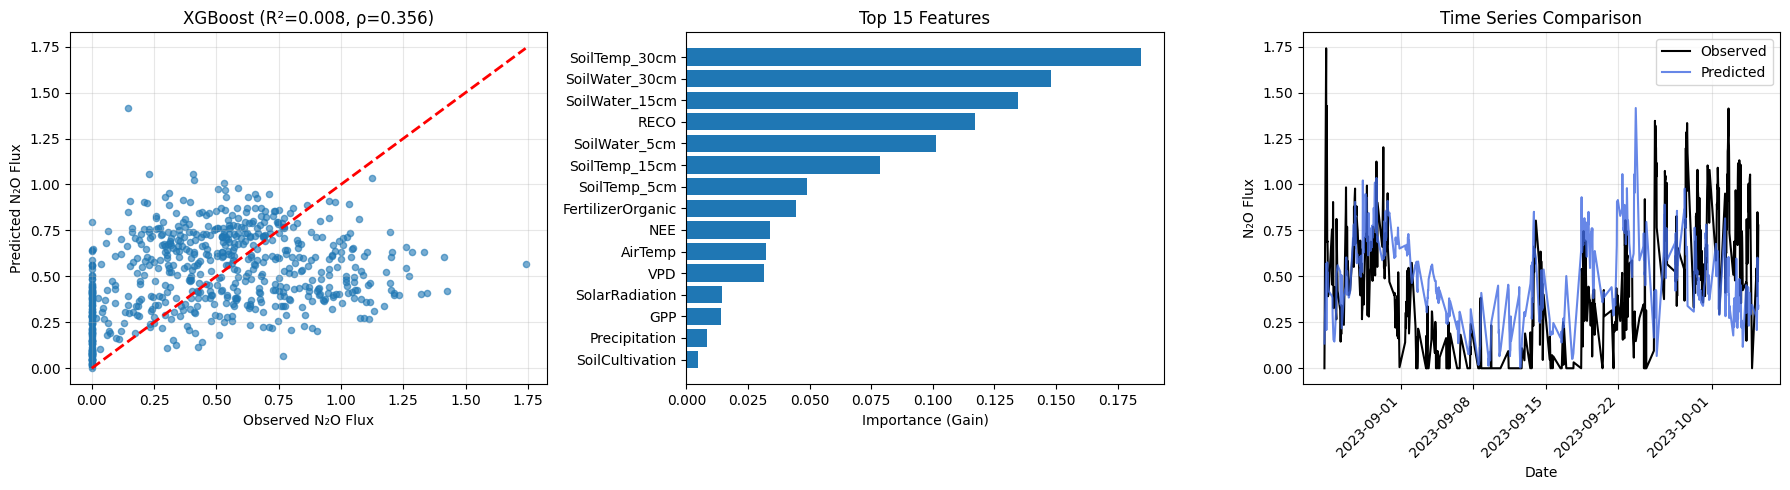


--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 2022-08-30 11:45:00 → 2023-08-15 09:15:00
Test  period: 2023-08-15 14:45:00 → 2023-10-05 12:15:00

Model evaluation:
  R² (linear scale): 0.128
  Spearman ρ:        0.483


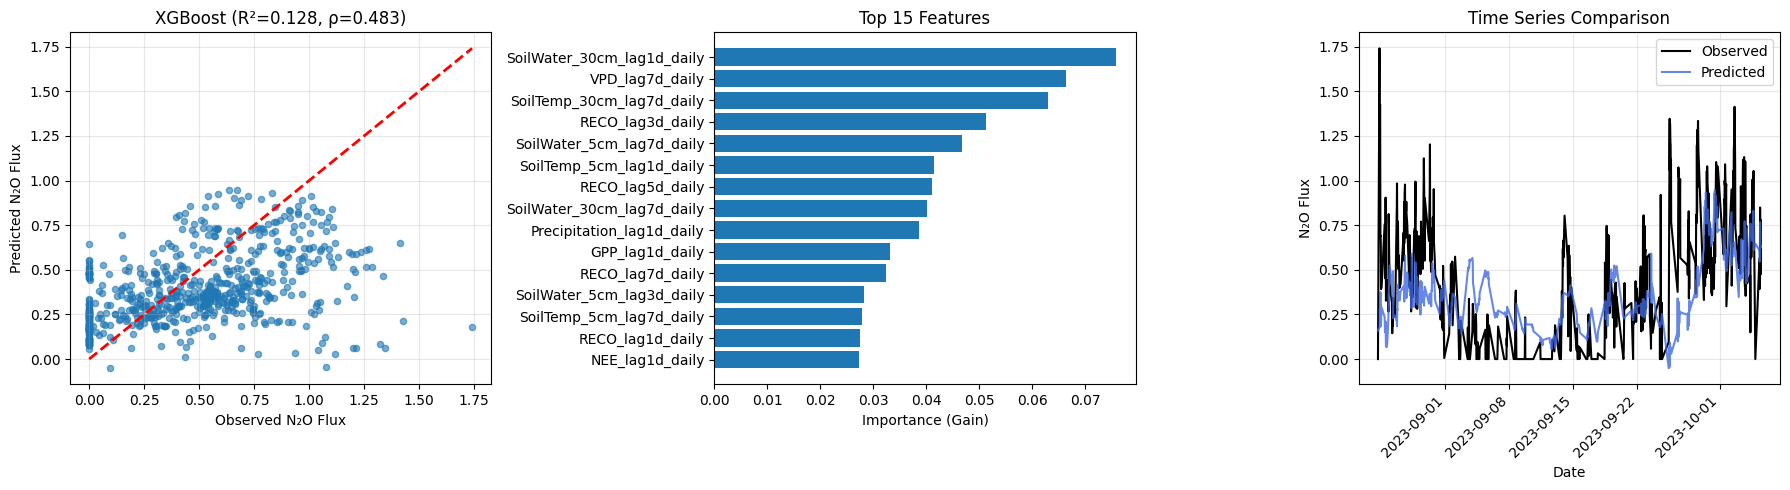


--- HOURLY | target=N2O_Flux_ln | predictors=AUGMENTED ---
Train period: 2022-08-30 11:45:00 → 2023-08-15 09:15:00
Test  period: 2023-08-15 14:45:00 → 2023-10-05 12:15:00

Model evaluation:
  R² (linear scale): 0.163
  Spearman ρ:        0.505


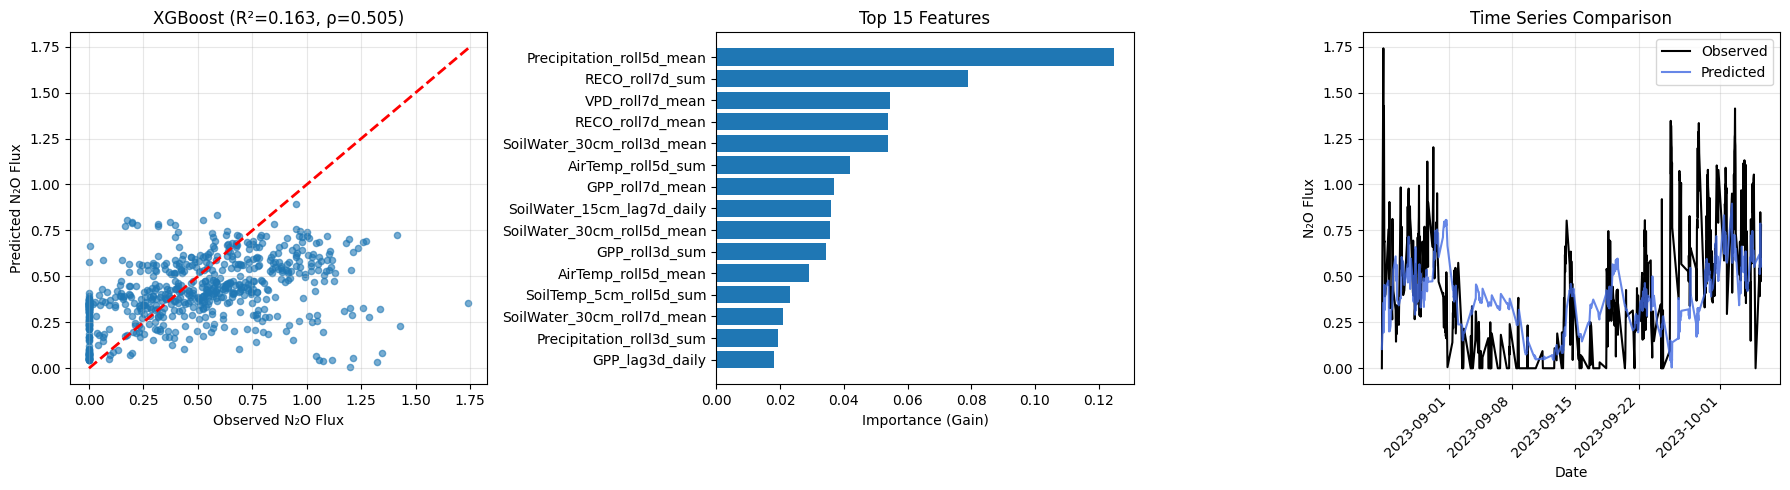


--- DAILY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 2022-08-30 00:00:00 → 2023-08-28 00:00:00
Test  period: 2023-08-29 00:00:00 → 2023-10-05 00:00:00

Model evaluation:
  R² (linear scale): 0.649
  Spearman ρ:        0.869


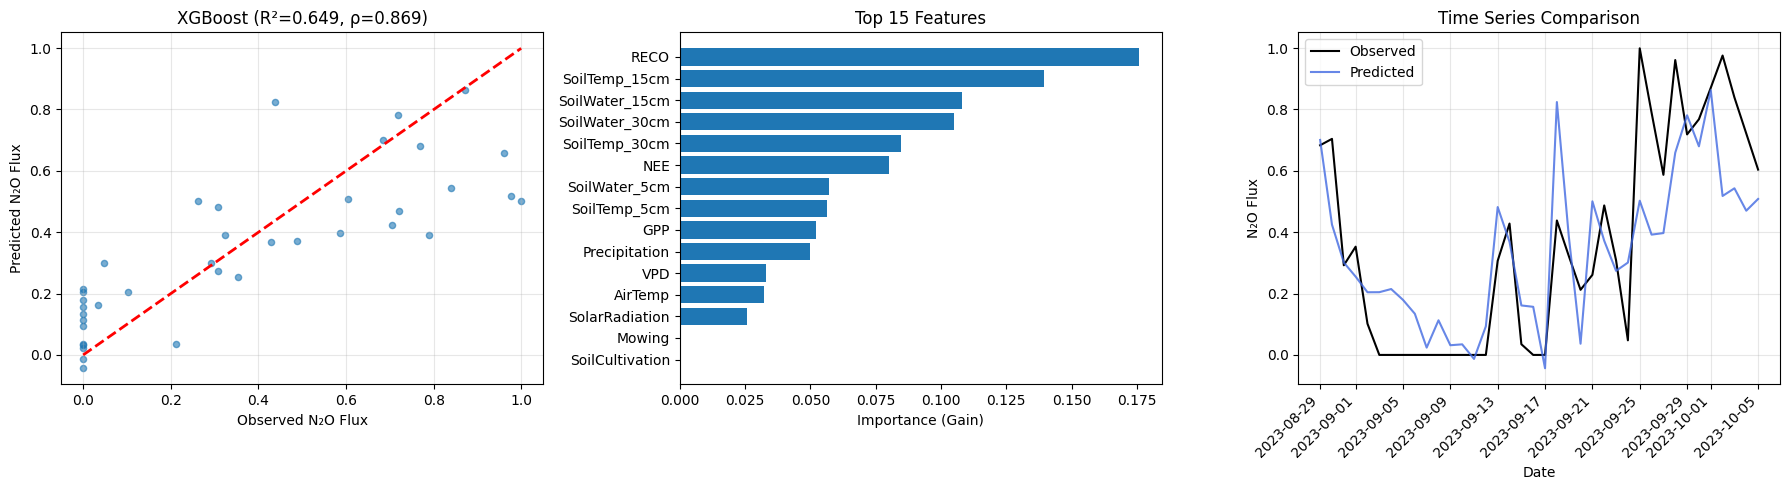


--- DAILY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 2022-08-30 00:00:00 → 2023-08-22 00:00:00
Test  period: 2023-08-23 00:00:00 → 2023-10-05 00:00:00

Model evaluation:
  R² (linear scale): 0.229
  Spearman ρ:        0.606


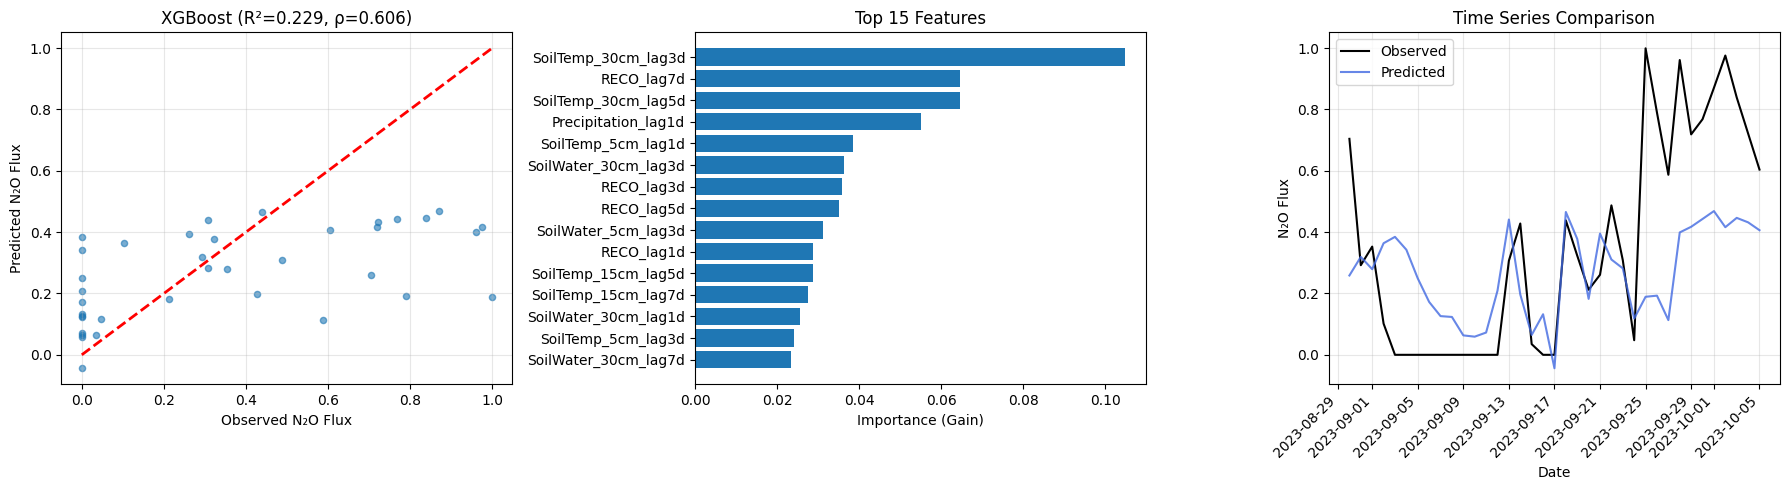


--- DAILY | target=N2O_Flux_ln | predictors=AUGMENTED ---
Train period: 2022-08-30 00:00:00 → 2023-08-22 00:00:00
Test  period: 2023-08-23 00:00:00 → 2023-10-05 00:00:00

Model evaluation:
  R² (linear scale): 0.057
  Spearman ρ:        0.393


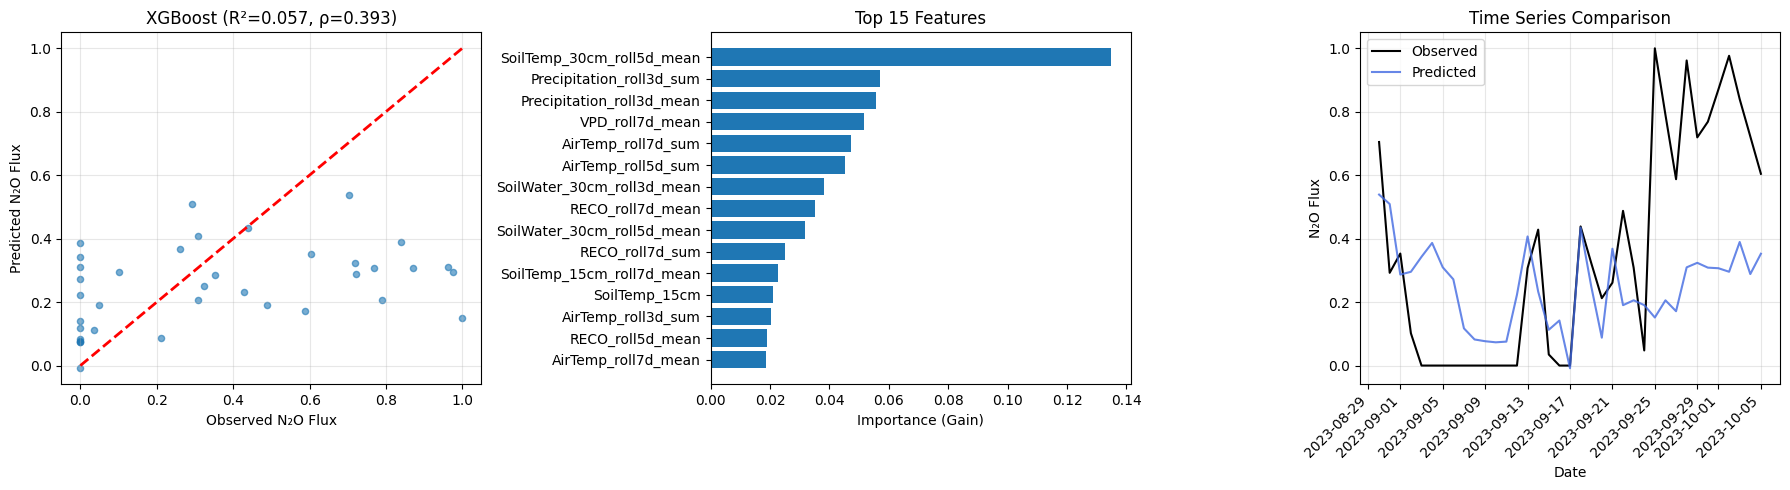


COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:
Temporal     Predictors   R²       Spearman ρ  
--------------------------------------------------------------------------------
Hourly       Base          0.008        0.356
Hourly       Lag           0.128        0.483
Hourly       Augmented     0.163        0.505
Daily        Base          0.649        0.869
Daily        Lag           0.229        0.606
Daily        Augmented     0.057        0.393

IMPROVEMENT FROM BASE TO LAG:
Hourly: R² +  0.120, ρ +  0.128
Daily:  R² + -0.420, ρ + -0.262

IMPROVEMENT FROM LAG TO AUGMENTED:
Hourly: R² +  0.035, ρ +  0.022
Daily:  R² + -0.172, ρ + -0.213


In [62]:
# ============================================================================
# OENSINGEN 2
# ============================================================================

print("="*80)
print("EXPERIMENT 2: Oensingen 2021-2023")
print("="*80)

# Define base and lag predictors
base_predictors = [
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
]

hourly_lag_predictors = [
    # --- Meteorological base variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",

    # --- Meteorological lag variables ---
    "NEE_lag1d_daily", "NEE_lag3d_daily", "NEE_lag5d_daily", "NEE_lag7d_daily",
    "GPP_lag1d_daily", "GPP_lag3d_daily", "GPP_lag5d_daily", "GPP_lag7d_daily",
    "RECO_lag1d_daily", "RECO_lag3d_daily", "RECO_lag5d_daily", "RECO_lag7d_daily",
    "SolarRadiation_lag1d_daily", "SolarRadiation_lag3d_daily", "SolarRadiation_lag5d_daily", "SolarRadiation_lag7d_daily",
    "AirTemp_lag1d_daily", "AirTemp_lag3d_daily", "AirTemp_lag5d_daily", "AirTemp_lag7d_daily",
    "VPD_lag1d_daily", "VPD_lag3d_daily", "VPD_lag5d_daily", "VPD_lag7d_daily",
    "SoilWater_5cm_lag1d_daily", "SoilWater_5cm_lag3d_daily", "SoilWater_5cm_lag5d_daily", "SoilWater_5cm_lag7d_daily",
    "SoilWater_15cm_lag1d_daily", "SoilWater_15cm_lag3d_daily", "SoilWater_15cm_lag5d_daily", "SoilWater_15cm_lag7d_daily",
    "SoilWater_30cm_lag1d_daily", "SoilWater_30cm_lag3d_daily", "SoilWater_30cm_lag5d_daily", "SoilWater_30cm_lag7d_daily",
    "SoilTemp_5cm_lag1d_daily", "SoilTemp_5cm_lag3d_daily", "SoilTemp_5cm_lag5d_daily", "SoilTemp_5cm_lag7d_daily",
    "SoilTemp_15cm_lag1d_daily", "SoilTemp_15cm_lag3d_daily", "SoilTemp_15cm_lag5d_daily", "SoilTemp_15cm_lag7d_daily",
    "SoilTemp_30cm_lag1d_daily", "SoilTemp_30cm_lag3d_daily", "SoilTemp_30cm_lag5d_daily", "SoilTemp_30cm_lag7d_daily",
    "Precipitation_lag1d_daily", "Precipitation_lag3d_daily", "Precipitation_lag5d_daily", "Precipitation_lag7d_daily",

    # --- Management variables ---
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_SoilCultivation"
]

hourly_augmented_predictors = [
    # --- Base current-day variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",
    
    # --- Lag features (1, 3, 5, 7 days) ---
    "NEE_lag1d_daily", "NEE_lag3d_daily", "NEE_lag5d_daily", "NEE_lag7d_daily",
    "GPP_lag1d_daily", "GPP_lag3d_daily", "GPP_lag5d_daily", "GPP_lag7d_daily",
    "RECO_lag1d_daily", "RECO_lag3d_daily", "RECO_lag5d_daily", "RECO_lag7d_daily",
    "SolarRadiation_lag1d_daily", "SolarRadiation_lag3d_daily", "SolarRadiation_lag5d_daily", "SolarRadiation_lag7d_daily",
    "AirTemp_lag1d_daily", "AirTemp_lag3d_daily", "AirTemp_lag5d_daily", "AirTemp_lag7d_daily",
    "VPD_lag1d_daily", "VPD_lag3d_daily", "VPD_lag5d_daily", "VPD_lag7d_daily",
    "SoilWater_5cm_lag1d_daily", "SoilWater_5cm_lag3d_daily", "SoilWater_5cm_lag5d_daily", "SoilWater_5cm_lag7d_daily",
    "SoilWater_15cm_lag1d_daily", "SoilWater_15cm_lag3d_daily", "SoilWater_15cm_lag5d_daily", "SoilWater_15cm_lag7d_daily",
    "SoilWater_30cm_lag1d_daily", "SoilWater_30cm_lag3d_daily", "SoilWater_30cm_lag5d_daily", "SoilWater_30cm_lag7d_daily",
    "SoilTemp_5cm_lag1d_daily", "SoilTemp_5cm_lag3d_daily", "SoilTemp_5cm_lag5d_daily", "SoilTemp_5cm_lag7d_daily",
    "SoilTemp_15cm_lag1d_daily", "SoilTemp_15cm_lag3d_daily", "SoilTemp_15cm_lag5d_daily", "SoilTemp_15cm_lag7d_daily",
    "SoilTemp_30cm_lag1d_daily", "SoilTemp_30cm_lag3d_daily", "SoilTemp_30cm_lag5d_daily", "SoilTemp_30cm_lag7d_daily",
    "Precipitation_lag1d_daily", "Precipitation_lag3d_daily", "Precipitation_lag5d_daily", "Precipitation_lag7d_daily",
    
    # --- Rolling mean features (3, 5, 7 day windows) ---
    "NEE_roll3d_mean", "NEE_roll5d_mean", "NEE_roll7d_mean",
    "GPP_roll3d_mean", "GPP_roll5d_mean", "GPP_roll7d_mean",
    "RECO_roll3d_mean", "RECO_roll5d_mean", "RECO_roll7d_mean",
    "SolarRadiation_roll3d_mean", "SolarRadiation_roll5d_mean", "SolarRadiation_roll7d_mean",
    "AirTemp_roll3d_mean", "AirTemp_roll5d_mean", "AirTemp_roll7d_mean",
    "VPD_roll3d_mean", "VPD_roll5d_mean", "VPD_roll7d_mean",
    "SoilWater_5cm_roll3d_mean", "SoilWater_5cm_roll5d_mean", "SoilWater_5cm_roll7d_mean",
    "SoilWater_15cm_roll3d_mean", "SoilWater_15cm_roll5d_mean", "SoilWater_15cm_roll7d_mean",
    "SoilWater_30cm_roll3d_mean", "SoilWater_30cm_roll5d_mean", "SoilWater_30cm_roll7d_mean",
    "SoilTemp_5cm_roll3d_mean", "SoilTemp_5cm_roll5d_mean", "SoilTemp_5cm_roll7d_mean",
    "SoilTemp_15cm_roll3d_mean", "SoilTemp_15cm_roll5d_mean", "SoilTemp_15cm_roll7d_mean",
    "SoilTemp_30cm_roll3d_mean", "SoilTemp_30cm_roll5d_mean", "SoilTemp_30cm_roll7d_mean",
    "Precipitation_roll3d_mean", "Precipitation_roll5d_mean", "Precipitation_roll7d_mean",
    
    # --- Rolling sum features (3, 5, 7 day windows) ---
    "NEE_roll3d_sum", "NEE_roll5d_sum", "NEE_roll7d_sum",
    "GPP_roll3d_sum", "GPP_roll5d_sum", "GPP_roll7d_sum",
    "RECO_roll3d_sum", "RECO_roll5d_sum", "RECO_roll7d_sum",
    "SolarRadiation_roll3d_sum", "SolarRadiation_roll5d_sum", "SolarRadiation_roll7d_sum",
    "AirTemp_roll3d_sum", "AirTemp_roll5d_sum", "AirTemp_roll7d_sum",
    "VPD_roll3d_sum", "VPD_roll5d_sum", "VPD_roll7d_sum",
    "SoilWater_5cm_roll3d_sum", "SoilWater_5cm_roll5d_sum", "SoilWater_5cm_roll7d_sum",
    "SoilWater_15cm_roll3d_sum", "SoilWater_15cm_roll5d_sum", "SoilWater_15cm_roll7d_sum",
    "SoilWater_30cm_roll3d_sum", "SoilWater_30cm_roll5d_sum", "SoilWater_30cm_roll7d_sum",
    "SoilTemp_5cm_roll3d_sum", "SoilTemp_5cm_roll5d_sum", "SoilTemp_5cm_roll7d_sum",
    "SoilTemp_15cm_roll3d_sum", "SoilTemp_15cm_roll5d_sum", "SoilTemp_15cm_roll7d_sum",
    "SoilTemp_30cm_roll3d_sum", "SoilTemp_30cm_roll5d_sum", "SoilTemp_30cm_roll7d_sum",
    "Precipitation_roll3d_sum", "Precipitation_roll5d_sum", "Precipitation_roll7d_sum",
    
    # Management events and days since
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_SoilCultivation"
]

daily_lag_predictors = [
    # --- Meteorological base variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",

    # --- Meteorological lag variables ---
    "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
    "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
    "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
    "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
    "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
    "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
    "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
    "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
    "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
    "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
    "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
    "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
    "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",

    # --- Management variables ---
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_SoilCultivation"
]

daily_augmented_predictors = [
    # --- Base current-day variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",
    
    # --- Lag features (1, 3, 5, 7 days) ---
    "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
    "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
    "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
    "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
    "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
    "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
    "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
    "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
    "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
    "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
    "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
    "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
    "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
    
    # --- Rolling mean features (3, 5, 7 day windows) ---
    "NEE_roll3d_mean", "NEE_roll5d_mean", "NEE_roll7d_mean",
    "GPP_roll3d_mean", "GPP_roll5d_mean", "GPP_roll7d_mean",
    "RECO_roll3d_mean", "RECO_roll5d_mean", "RECO_roll7d_mean",
    "SolarRadiation_roll3d_mean", "SolarRadiation_roll5d_mean", "SolarRadiation_roll7d_mean",
    "AirTemp_roll3d_mean", "AirTemp_roll5d_mean", "AirTemp_roll7d_mean",
    "VPD_roll3d_mean", "VPD_roll5d_mean", "VPD_roll7d_mean",
    "SoilWater_5cm_roll3d_mean", "SoilWater_5cm_roll5d_mean", "SoilWater_5cm_roll7d_mean",
    "SoilWater_15cm_roll3d_mean", "SoilWater_15cm_roll5d_mean", "SoilWater_15cm_roll7d_mean",
    "SoilWater_30cm_roll3d_mean", "SoilWater_30cm_roll5d_mean", "SoilWater_30cm_roll7d_mean",
    "SoilTemp_5cm_roll3d_mean", "SoilTemp_5cm_roll5d_mean", "SoilTemp_5cm_roll7d_mean",
    "SoilTemp_15cm_roll3d_mean", "SoilTemp_15cm_roll5d_mean", "SoilTemp_15cm_roll7d_mean",
    "SoilTemp_30cm_roll3d_mean", "SoilTemp_30cm_roll5d_mean", "SoilTemp_30cm_roll7d_mean",
    "Precipitation_roll3d_mean", "Precipitation_roll5d_mean", "Precipitation_roll7d_mean",
    
    # --- Rolling sum features (3, 5, 7 day windows) ---
    "NEE_roll3d_sum", "NEE_roll5d_sum", "NEE_roll7d_sum",
    "GPP_roll3d_sum", "GPP_roll5d_sum", "GPP_roll7d_sum",
    "RECO_roll3d_sum", "RECO_roll5d_sum", "RECO_roll7d_sum",
    "SolarRadiation_roll3d_sum", "SolarRadiation_roll5d_sum", "SolarRadiation_roll7d_sum",
    "AirTemp_roll3d_sum", "AirTemp_roll5d_sum", "AirTemp_roll7d_sum",
    "VPD_roll3d_sum", "VPD_roll5d_sum", "VPD_roll7d_sum",
    "SoilWater_5cm_roll3d_sum", "SoilWater_5cm_roll5d_sum", "SoilWater_5cm_roll7d_sum",
    "SoilWater_15cm_roll3d_sum", "SoilWater_15cm_roll5d_sum", "SoilWater_15cm_roll7d_sum",
    "SoilWater_30cm_roll3d_sum", "SoilWater_30cm_roll5d_sum", "SoilWater_30cm_roll7d_sum",
    "SoilTemp_5cm_roll3d_sum", "SoilTemp_5cm_roll5d_sum", "SoilTemp_5cm_roll7d_sum",
    "SoilTemp_15cm_roll3d_sum", "SoilTemp_15cm_roll5d_sum", "SoilTemp_15cm_roll7d_sum",
    "SoilTemp_30cm_roll3d_sum", "SoilTemp_30cm_roll5d_sum", "SoilTemp_30cm_roll7d_sum",
    "Precipitation_roll3d_sum", "Precipitation_roll5d_sum", "Precipitation_roll7d_sum",
    
    # Management events and days since
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_SoilCultivation"
]

# Store results for comparison
all_results = []

# ============================================================================
# HOURLY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_hourly_base = train_xgb_timeseries(
    df=oensingen_2_lag,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Base", results_hourly_base['r2'], results_hourly_base['spearman_rho']))


# ============================================================================
# HOURLY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_hourly_lag = train_xgb_timeseries(
    df=oensingen_2_lag,
    predictors=hourly_lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Lag", results_hourly_lag['r2'], results_hourly_lag['spearman_rho']))


# ============================================================================
# HOURLY DATA - AUGMENTED PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=AUGMENTED ---")
print("="*80)

results_hourly_augmented = train_xgb_timeseries(
    df=oensingen_2_lag,
    predictors=hourly_augmented_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Augmented", results_hourly_augmented['r2'], results_hourly_augmented['spearman_rho']))

# ============================================================================
# DAILY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_daily_base = train_xgb_timeseries(
    df=oensingen_2_daily,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Base", results_daily_base['r2'], results_daily_base['spearman_rho']))

# ============================================================================
# DAILY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_daily_lag = train_xgb_timeseries(
    df=oensingen_2_daily,
    predictors=daily_lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Lag", results_daily_lag['r2'], results_daily_lag['spearman_rho']))


# ============================================================================
# DAILY DATA - AUGMENTED PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=AUGMENTED ---")
print("="*80)

results_daily_augmented = train_xgb_timeseries(
    df=oensingen_2_daily,
    predictors=daily_augmented_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Augmented", results_daily_augmented['r2'], results_daily_augmented['spearman_rho']))

# ============================================================================
# COMPREHENSIVE COMPARISON
# ============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:")
print("="*80)
print(f"{'Temporal':<12} {'Predictors':<12} {'R²':<8} {'Spearman ρ':<12}")
print("-"*80)
for temp, pred, r2, rho in all_results:
    print(f"{temp:<12} {pred:<12} {r2:>6.3f}   {rho:>10.3f}")

print("\n" + "="*80)
print("IMPROVEMENT FROM BASE TO LAG:")
print("="*80)
print(f"Hourly: R² + {(results_hourly_lag['r2'] - results_hourly_base['r2']):>6.3f}, ρ + {(results_hourly_lag['spearman_rho'] - results_hourly_base['spearman_rho']):>6.3f}")
print(f"Daily:  R² + {(results_daily_lag['r2'] - results_daily_base['r2']):>6.3f}, ρ + {(results_daily_lag['spearman_rho'] - results_daily_base['spearman_rho']):>6.3f}")

print("\n" + "="*80)
print("IMPROVEMENT FROM LAG TO AUGMENTED:")
print("="*80)
print(f"Hourly: R² + {(results_hourly_augmented['r2'] - results_hourly_lag['r2']):>6.3f}, ρ + {(results_hourly_augmented['spearman_rho'] - results_hourly_lag['spearman_rho']):>6.3f}")
print(f"Daily:  R² + {(results_daily_augmented['r2'] - results_daily_lag['r2']):>6.3f}, ρ + {(results_daily_augmented['spearman_rho'] - results_daily_lag['spearman_rho']):>6.3f}")

# Experiment 3: Aeschi dataset

In [70]:
# FIX TIMESTAMP
aeschi_lag['Timestamp'] = pd.to_datetime(aeschi_lag['Timestamp'])
aeschi_lag = aeschi_lag.set_index('Timestamp').sort_index()

aeschi_daily['Date'] = pd.to_datetime(aeschi_daily['Date'])
aeschi_daily = aeschi_daily.set_index('Date').sort_index()

In [51]:
def train_xgb_timeseries(df, predictors, target, test_size=0.1, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    
    Now includes a time series comparison plot showing observed vs predicted values over time.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    # Store test dates for time series plot
    test_dates = X_test.index
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        # Create 3-subplot figure: scatter, feature importance, and TIME SERIES
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.3f}, ρ={rho:.3f})")
        axes[0].grid(True, alpha=0.3)
        
        # 2. Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        # 3. TIME SERIES COMPARISON (NEW!)
        axes[2].plot(test_dates, y_test_lin.values, label="Observed", color="black", lw=1.5)
        axes[2].plot(test_dates, y_pred_lin, label="Predicted", color="royalblue", lw=1.5, alpha=0.8)
        axes[2].set_xlabel("Date")
        axes[2].set_ylabel("N₂O Flux")
        axes[2].set_title("Time Series Comparison")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
        "test_dates": test_dates,  # Also return test dates
    }

EXPERIMENT 3: Aeschi 2019-2020

--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 2019-07-03 14:45:00 → 2020-10-27 03:15:00
Test  period: 2020-10-27 03:45:00 → 2020-11-02 17:45:00

Model evaluation:
  R² (linear scale): -2.066
  Spearman ρ:        0.080


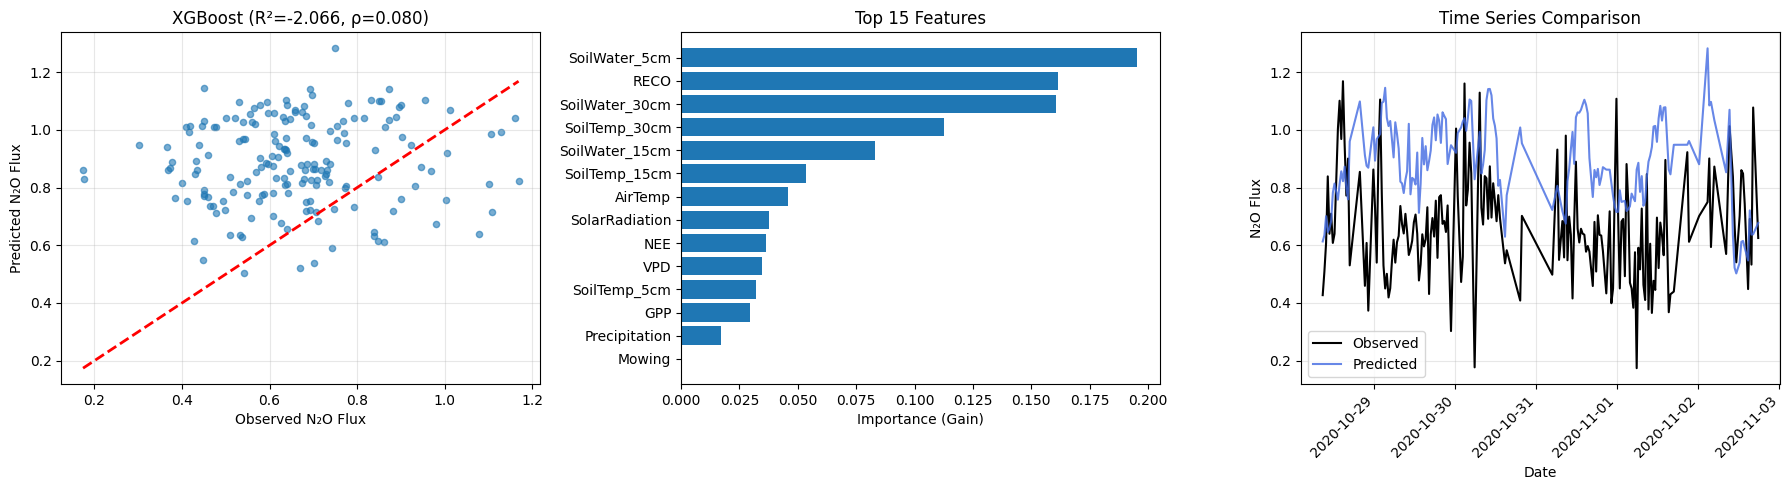


--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 2019-07-03 14:45:00 → 2020-10-11 08:45:00
Test  period: 2020-10-11 09:15:00 → 2020-11-02 17:45:00

Model evaluation:
  R² (linear scale): -0.331
  Spearman ρ:        0.190


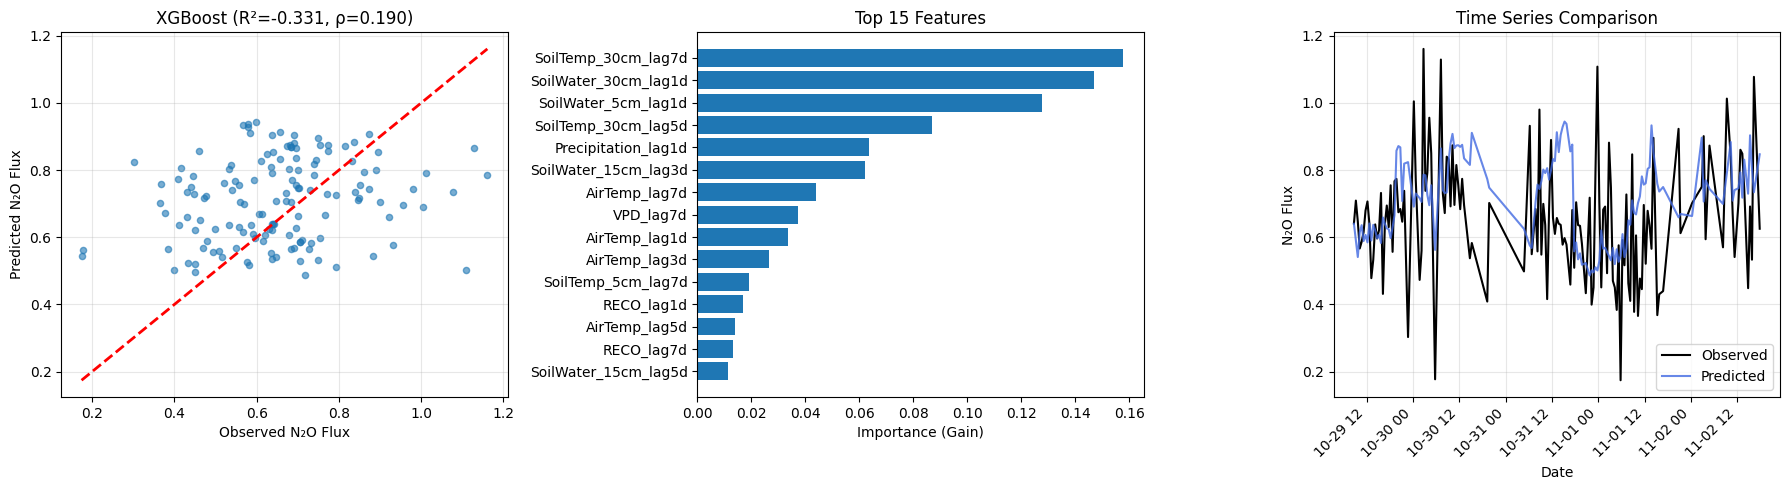


--- HOURLY | target=N2O_Flux_ln | predictors=AUGMENTED ---
Train period: 2019-07-03 14:45:00 → 2020-10-11 08:45:00
Test  period: 2020-10-11 09:15:00 → 2020-11-02 17:45:00

Model evaluation:
  R² (linear scale): -1.621
  Spearman ρ:        0.163


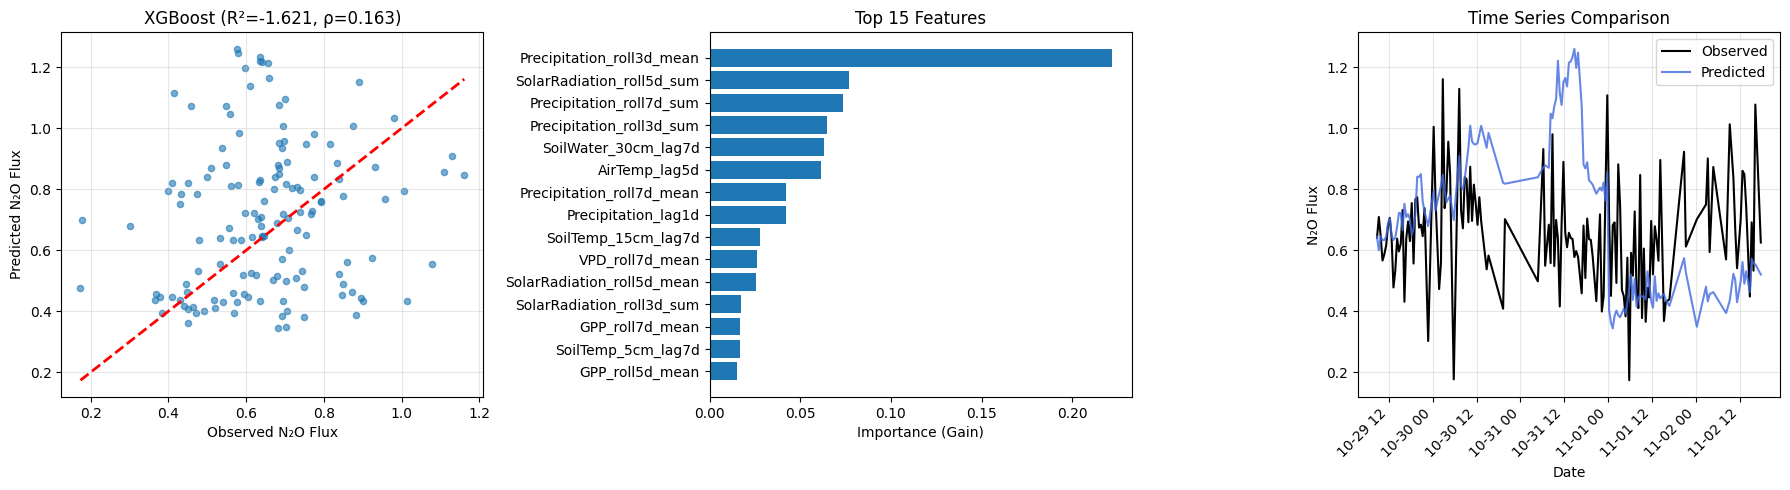


--- DAILY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 2019-07-03 00:00:00 → 2020-10-26 00:00:00
Test  period: 2020-10-27 00:00:00 → 2020-11-02 00:00:00

Model evaluation:
  R² (linear scale): -2.135
  Spearman ρ:        0.214


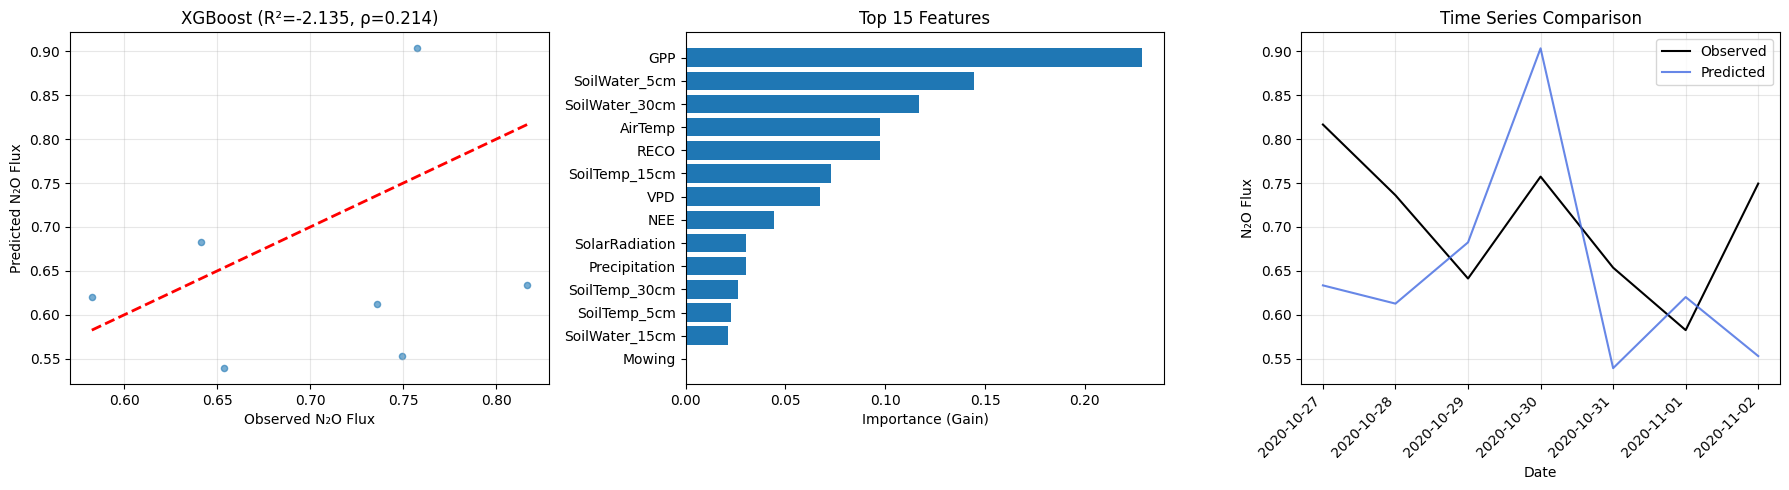


--- DAILY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 2019-07-03 00:00:00 → 2020-10-20 00:00:00
Test  period: 2020-10-21 00:00:00 → 2020-11-02 00:00:00

Model evaluation:
  R² (linear scale): -1.966
  Spearman ρ:        0.600


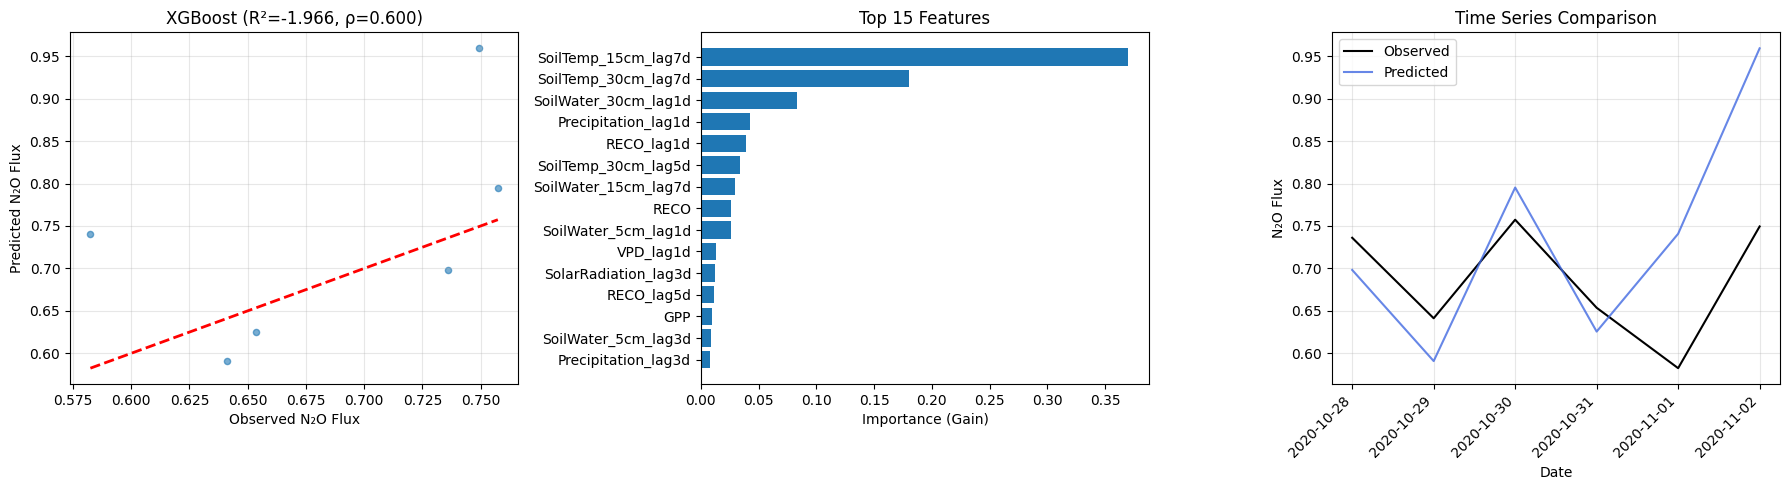


--- DAILY | target=N2O_Flux_ln | predictors=AUGMENTED ---
Train period: 2019-07-03 00:00:00 → 2020-10-20 00:00:00
Test  period: 2020-10-21 00:00:00 → 2020-11-02 00:00:00

Model evaluation:
  R² (linear scale): -0.177
  Spearman ρ:        0.943


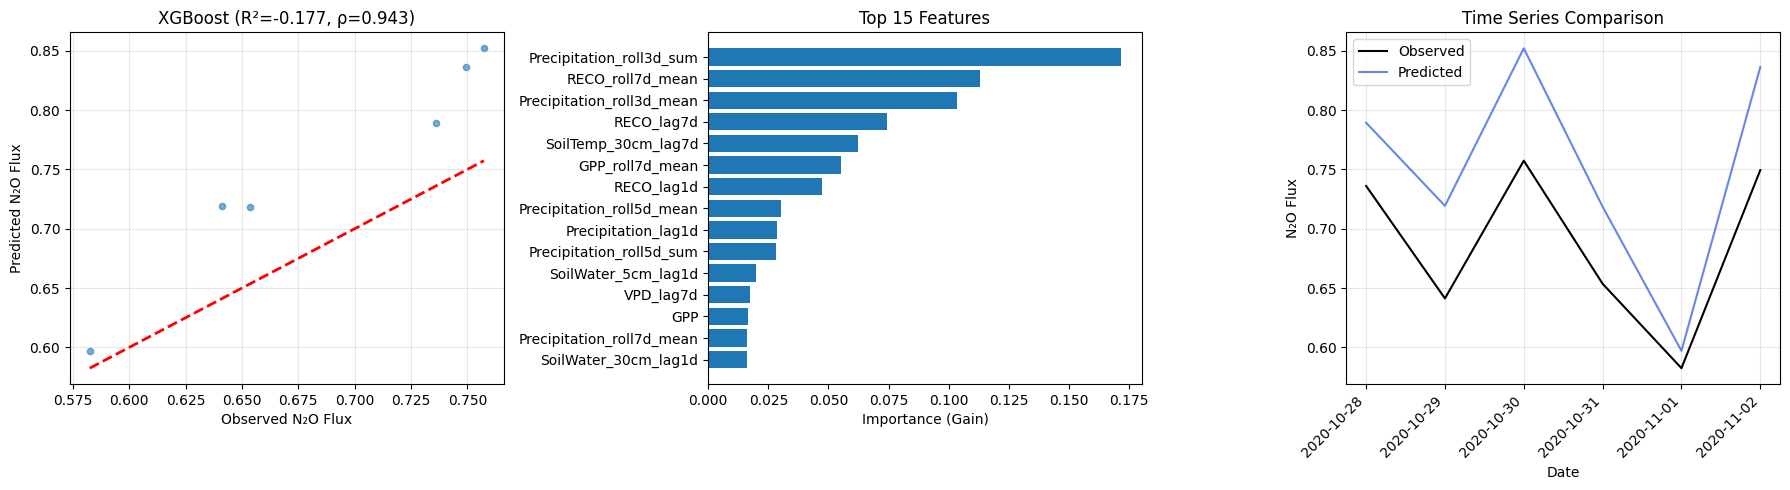


COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:
Temporal     Predictors   R²       Spearman ρ  
--------------------------------------------------------------------------------
Hourly       Base         -2.066        0.080
Hourly       Lag          -0.331        0.190
Hourly       Augmented    -1.621        0.163
Daily        Base         -2.135        0.214
Daily        Lag          -1.966        0.600
Daily        Augmented    -0.177        0.943

IMPROVEMENT FROM BASE TO LAG:
Hourly: R² +  1.735, ρ +  0.110
Daily:  R² +  0.169, ρ +  0.386

IMPROVEMENT FROM LAG TO AUGMENTED:
Hourly: R² + -1.290, ρ + -0.027
Daily:  R² +  1.789, ρ +  0.343


In [55]:
# ============================================================================
# AESCHI
# ============================================================================

print("="*80)
print("EXPERIMENT 3: Aeschi 2019-2020")
print("="*80)

# Define base and lag predictors
base_predictors = [
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",
    "Mowing",
]

lag_predictors = [
    # --- Meteorological base variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",

    # --- Meteorological lag variables ---
    "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
    "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
    "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
    "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
    "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
    "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
    "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
    "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
    "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
    "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
    "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
    "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
    "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",

    # --- Management variables ---
    "Mowing", "DaysSince_Mowing"
]

augmented_predictors = [
    # --- Base current-day variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",
    
    # --- Lag features (1, 3, 5, 7 days) ---
    "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
    "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
    "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
    "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
    "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
    "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
    "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
    "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
    "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
    "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
    "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
    "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
    "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
    
    # --- Rolling mean features (3, 5, 7 day windows) ---
    "NEE_roll3d_mean", "NEE_roll5d_mean", "NEE_roll7d_mean",
    "GPP_roll3d_mean", "GPP_roll5d_mean", "GPP_roll7d_mean",
    "RECO_roll3d_mean", "RECO_roll5d_mean", "RECO_roll7d_mean",
    "SolarRadiation_roll3d_mean", "SolarRadiation_roll5d_mean", "SolarRadiation_roll7d_mean",
    "AirTemp_roll3d_mean", "AirTemp_roll5d_mean", "AirTemp_roll7d_mean",
    "VPD_roll3d_mean", "VPD_roll5d_mean", "VPD_roll7d_mean",
    "SoilWater_5cm_roll3d_mean", "SoilWater_5cm_roll5d_mean", "SoilWater_5cm_roll7d_mean",
    "SoilWater_15cm_roll3d_mean", "SoilWater_15cm_roll5d_mean", "SoilWater_15cm_roll7d_mean",
    "SoilTemp_5cm_roll3d_mean", "SoilTemp_5cm_roll5d_mean", "SoilTemp_5cm_roll7d_mean",
    "SoilTemp_15cm_roll3d_mean", "SoilTemp_15cm_roll5d_mean", "SoilTemp_15cm_roll7d_mean",
    "Precipitation_roll3d_mean", "Precipitation_roll5d_mean", "Precipitation_roll7d_mean",
    
    # --- Rolling sum features (3, 5, 7 day windows) ---
    "NEE_roll3d_sum", "NEE_roll5d_sum", "NEE_roll7d_sum",
    "GPP_roll3d_sum", "GPP_roll5d_sum", "GPP_roll7d_sum",
    "RECO_roll3d_sum", "RECO_roll5d_sum", "RECO_roll7d_sum",
    "SolarRadiation_roll3d_sum", "SolarRadiation_roll5d_sum", "SolarRadiation_roll7d_sum",
    "AirTemp_roll3d_sum", "AirTemp_roll5d_sum", "AirTemp_roll7d_sum",
    "VPD_roll3d_sum", "VPD_roll5d_sum", "VPD_roll7d_sum",
    "SoilWater_5cm_roll3d_sum", "SoilWater_5cm_roll5d_sum", "SoilWater_5cm_roll7d_sum",
    "SoilWater_15cm_roll3d_sum", "SoilWater_15cm_roll5d_sum", "SoilWater_15cm_roll7d_sum",
    "SoilTemp_5cm_roll3d_sum", "SoilTemp_5cm_roll5d_sum", "SoilTemp_5cm_roll7d_sum",
    "SoilTemp_15cm_roll3d_sum", "SoilTemp_15cm_roll5d_sum", "SoilTemp_15cm_roll7d_sum",
    "Precipitation_roll3d_sum", "Precipitation_roll5d_sum", "Precipitation_roll7d_sum",
    
    # --- Management variables ---
    "Mowing", "DaysSince_Mowing"
]

# Store results for comparison
all_results = []

# ============================================================================
# HOURLY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_hourly_base = train_xgb_timeseries(
    df=aeschi_lag,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Base", results_hourly_base['r2'], results_hourly_base['spearman_rho']))


# ============================================================================
# HOURLY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_hourly_lag = train_xgb_timeseries(
    df=aeschi_lag,
    predictors=lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Lag", results_hourly_lag['r2'], results_hourly_lag['spearman_rho']))


# ============================================================================
# HOURLY DATA - AUGMENTED PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=AUGMENTED ---")
print("="*80)

results_hourly_augmented = train_xgb_timeseries(
    df=aeschi_lag,
    predictors=augmented_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Augmented", results_hourly_augmented['r2'], results_hourly_augmented['spearman_rho']))

# ============================================================================
# DAILY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_daily_base = train_xgb_timeseries(
    df=aeschi_daily,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Base", results_daily_base['r2'], results_daily_base['spearman_rho']))

# ============================================================================
# DAILY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_daily_lag = train_xgb_timeseries(
    df=aeschi_daily,
    predictors=lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Lag", results_daily_lag['r2'], results_daily_lag['spearman_rho']))


# ============================================================================
# DAILY DATA - AUGMENTED PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=AUGMENTED ---")
print("="*80)

results_daily_augmented = train_xgb_timeseries(
    df=aeschi_daily,
    predictors=augmented_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Augmented", results_daily_augmented['r2'], results_daily_augmented['spearman_rho']))

# ============================================================================
# COMPREHENSIVE COMPARISON
# ============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:")
print("="*80)
print(f"{'Temporal':<12} {'Predictors':<12} {'R²':<8} {'Spearman ρ':<12}")
print("-"*80)
for temp, pred, r2, rho in all_results:
    print(f"{temp:<12} {pred:<12} {r2:>6.3f}   {rho:>10.3f}")

print("\n" + "="*80)
print("IMPROVEMENT FROM BASE TO LAG:")
print("="*80)
print(f"Hourly: R² + {(results_hourly_lag['r2'] - results_hourly_base['r2']):>6.3f}, ρ + {(results_hourly_lag['spearman_rho'] - results_hourly_base['spearman_rho']):>6.3f}")
print(f"Daily:  R² + {(results_daily_lag['r2'] - results_daily_base['r2']):>6.3f}, ρ + {(results_daily_lag['spearman_rho'] - results_daily_base['spearman_rho']):>6.3f}")

print("\n" + "="*80)
print("IMPROVEMENT FROM LAG TO AUGMENTED:")
print("="*80)
print(f"Hourly: R² + {(results_hourly_augmented['r2'] - results_hourly_lag['r2']):>6.3f}, ρ + {(results_hourly_augmented['spearman_rho'] - results_hourly_lag['spearman_rho']):>6.3f}")
print(f"Daily:  R² + {(results_daily_augmented['r2'] - results_daily_lag['r2']):>6.3f}, ρ + {(results_daily_augmented['spearman_rho'] - results_daily_lag['spearman_rho']):>6.3f}")

# Experiment 4: Chamau dataset

In [71]:
# FIX TIMESTAMP
chamau_lag['Timestamp'] = pd.to_datetime(chamau_lag['Timestamp'])
chamau_lag = chamau_lag.set_index('Timestamp').sort_index()

chamau_daily['Date'] = pd.to_datetime(chamau_daily['Date'])
chamau_daily = chamau_daily.sort_values('Date')

# SPLIT BY PARCEL
chamau_A = chamau_lag[chamau_lag['Parcel'] == 'A'].copy()
chamau_B = chamau_lag[chamau_lag['Parcel'] == 'B'].copy()
chamau_daily_A = chamau_daily[chamau_daily['Parcel'] == 'A'].set_index('Date')
chamau_daily_B = chamau_daily[chamau_daily['Parcel'] == 'B'].set_index('Date')

In [44]:
def train_xgb_timeseries(df, predictors, target, test_size=0.1, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    
    Now includes a time series comparison plot showing observed vs predicted values over time.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    # Store test dates for time series plot
    test_dates = X_test.index
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        # Create 3-subplot figure: scatter, feature importance, and TIME SERIES
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.3f}, ρ={rho:.3f})")
        axes[0].grid(True, alpha=0.3)
        
        # 2. Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        # 3. TIME SERIES COMPARISON (NEW!)
        axes[2].plot(test_dates, y_test_lin.values, label="Observed", color="black", lw=1.5)
        axes[2].plot(test_dates, y_pred_lin, label="Predicted", color="royalblue", lw=1.5, alpha=0.8)
        axes[2].set_xlabel("Date")
        axes[2].set_ylabel("N₂O Flux")
        axes[2].set_title("Time Series Comparison")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
        "test_dates": test_dates,  # Also return test dates
    }

EXPERIMENT 4: Chamau 2014-2024

--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 2014-01-01 08:15:00 → 2021-07-31 12:15:00
Test  period: 2021-07-31 13:15:00 → 2022-07-06 09:15:00

Model evaluation:
  R² (linear scale): 0.145
  Spearman ρ:        0.321


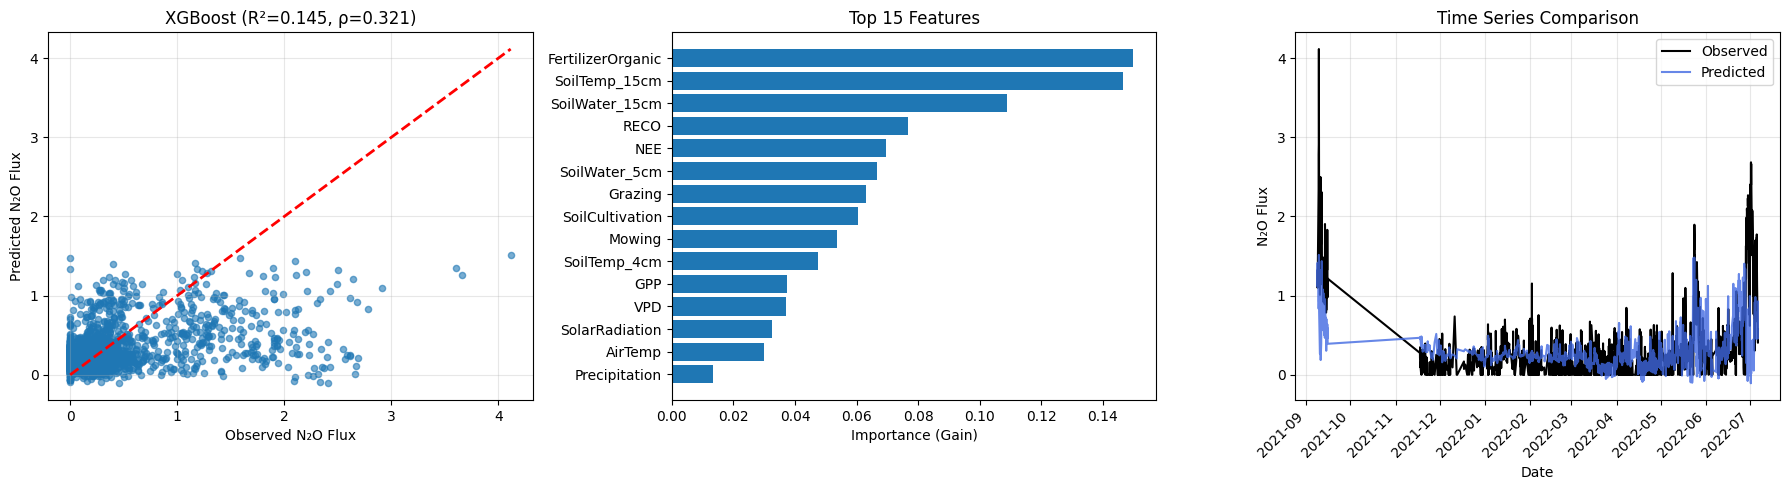


--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 2014-01-01 08:15:00 → 2021-06-29 15:45:00
Test  period: 2021-06-29 17:15:00 → 2022-07-06 09:15:00

Model evaluation:
  R² (linear scale): 0.269
  Spearman ρ:        0.528


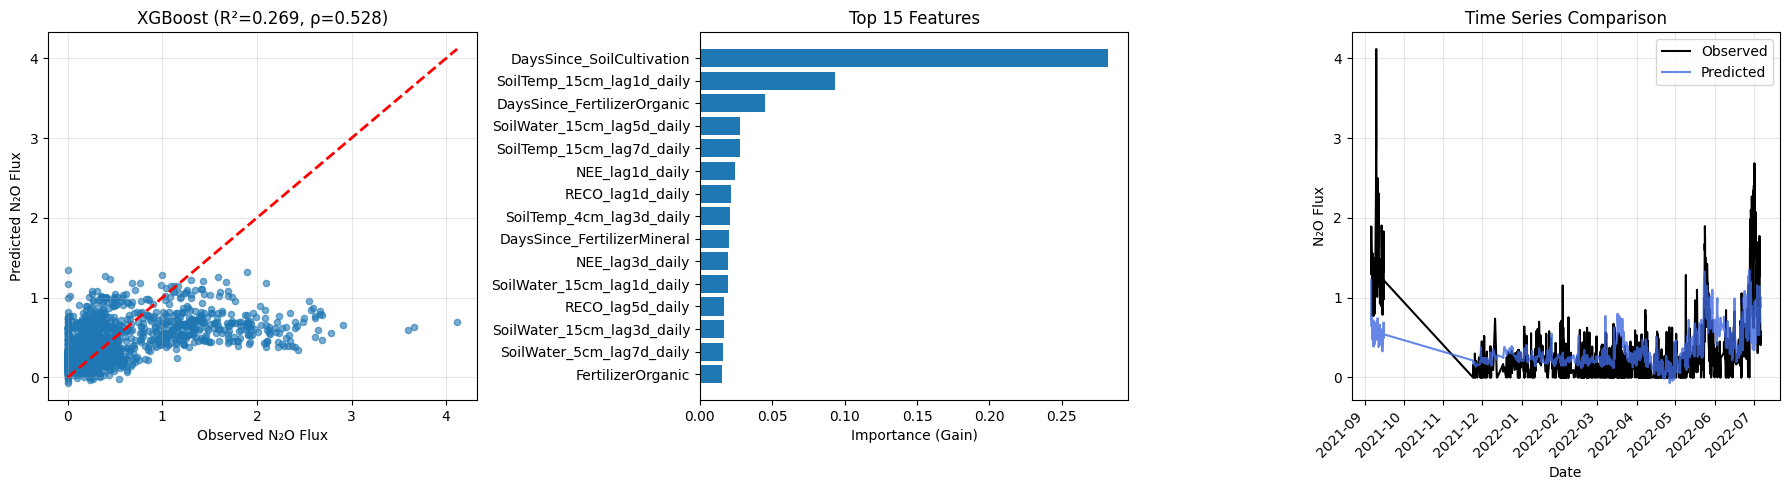


--- HOURLY | target=N2O_Flux_ln | predictors=AUGMENTED ---
Train period: 2014-01-01 08:15:00 → 2021-06-29 15:45:00
Test  period: 2021-06-29 17:15:00 → 2022-07-06 09:15:00

Model evaluation:
  R² (linear scale): 0.283
  Spearman ρ:        0.553


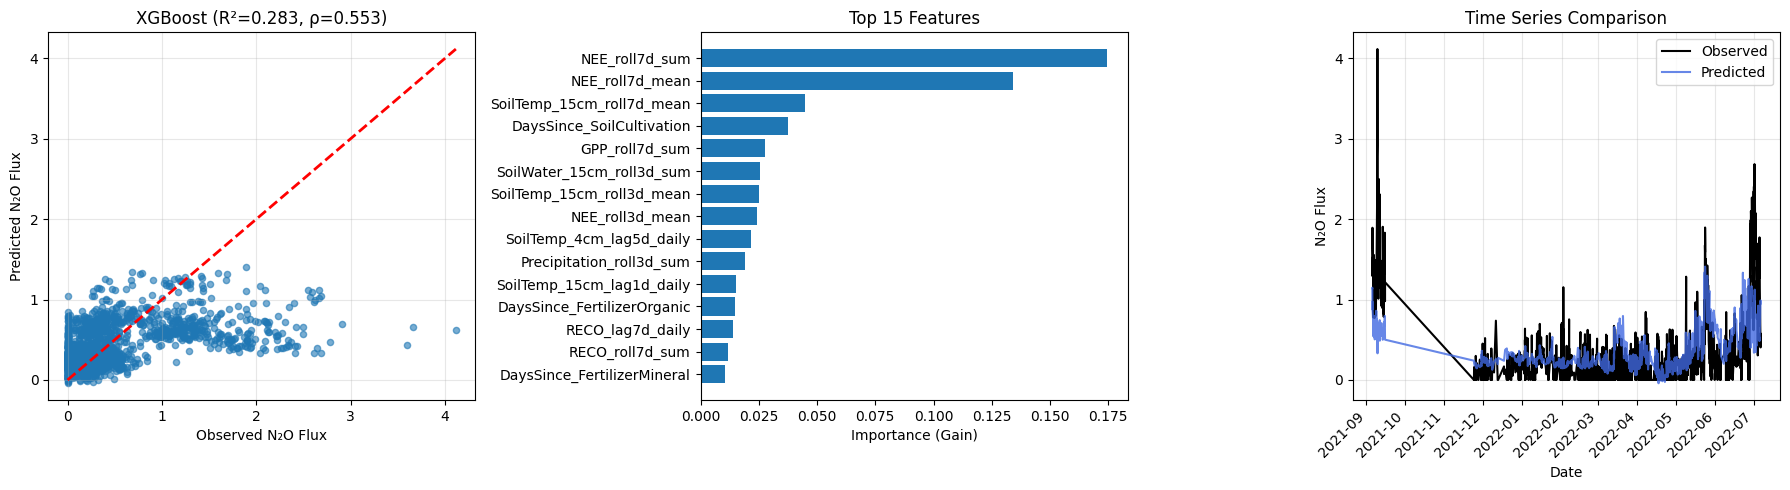


--- DAILY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 0 → 3689
Test  period: 3690 → 4338

Model evaluation:
  R² (linear scale): 0.762
  Spearman ρ:        0.582


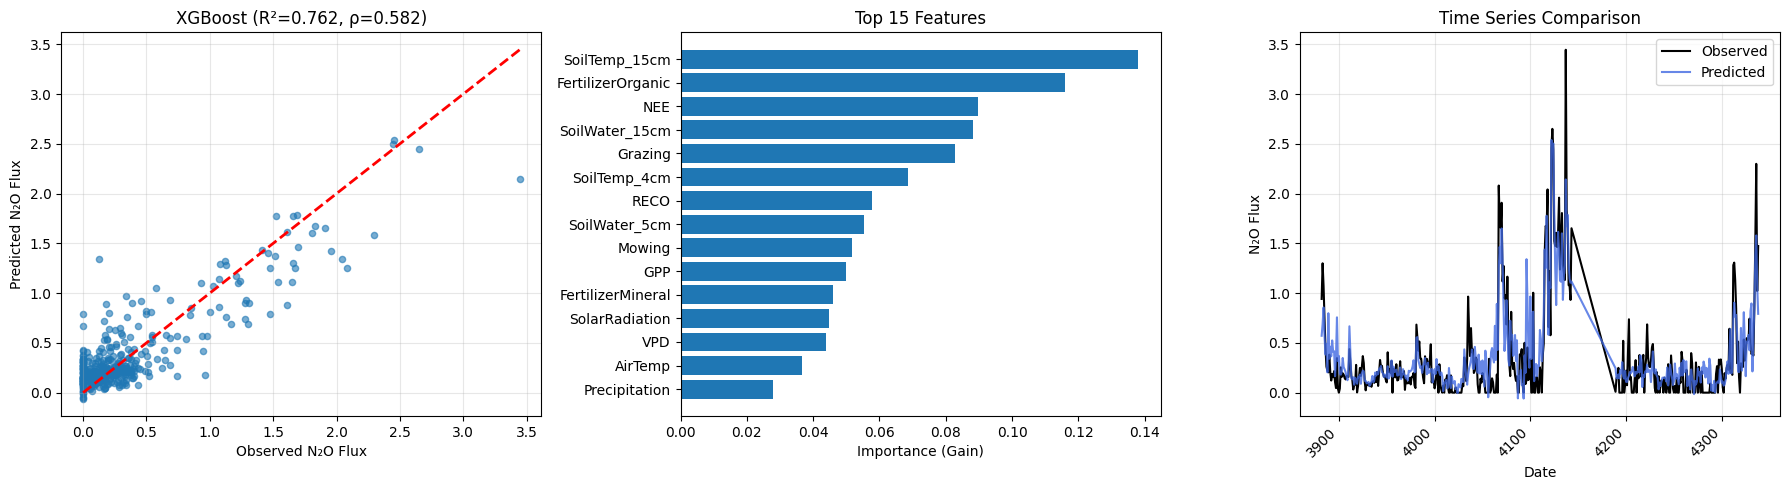


--- DAILY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 0 → 3642
Test  period: 3643 → 4338

Model evaluation:
  R² (linear scale): 0.831
  Spearman ρ:        0.626


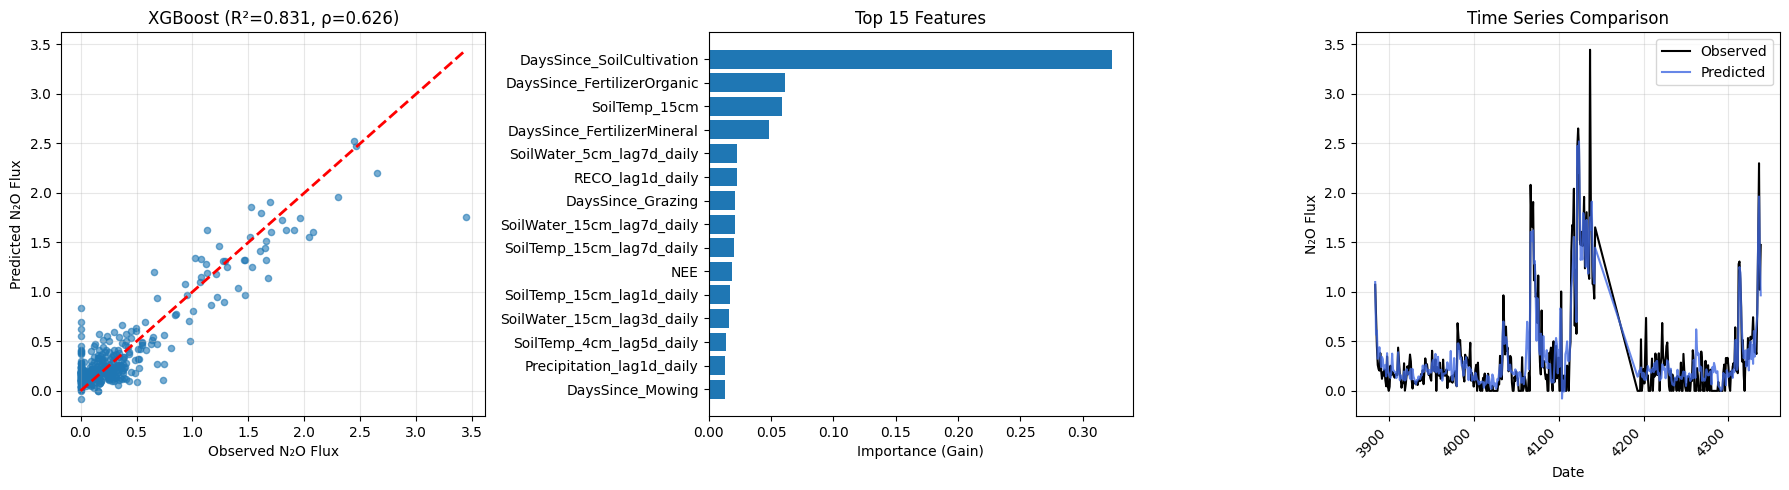


--- DAILY | target=N2O_Flux_ln | predictors=AUGMENTED ---
Train period: 0 → 3642
Test  period: 3643 → 4338

Model evaluation:
  R² (linear scale): 0.799
  Spearman ρ:        0.605


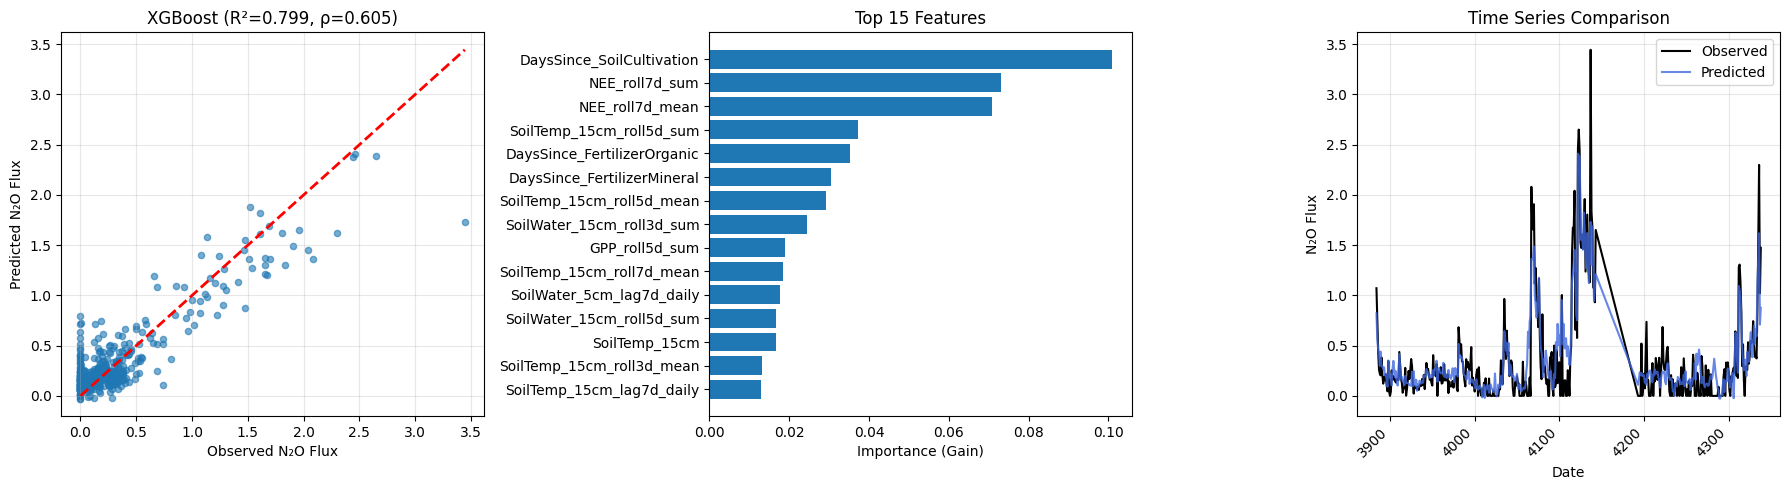


COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:
Temporal     Predictors   R²       Spearman ρ  
--------------------------------------------------------------------------------
Hourly       Base          0.145        0.321
Hourly       Lag           0.269        0.528
Hourly       Augmented     0.283        0.553
Daily        Base          0.762        0.582
Daily        Lag           0.831        0.626
Daily        Augmented     0.799        0.605

IMPROVEMENT FROM BASE TO LAG:
Hourly: R² +  0.124, ρ +  0.208
Daily:  R² +  0.069, ρ +  0.044

IMPROVEMENT FROM LAG TO AUGMENTED:
Hourly: R² +  0.014, ρ +  0.025
Daily:  R² + -0.032, ρ + -0.021


In [49]:
# ============================================================================
# CHAMAU
# ============================================================================

print("="*80)
print("EXPERIMENT 4: Chamau 2014-2024")
print("="*80)

# Define base and lag predictors
base_predictors = [
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm",
    "SoilTemp_4cm", "SoilTemp_15cm",
    "NEE", "GPP", "RECO",
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation"
]

lag_predictors = [
    # --- Meteorological base variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm",
    "SoilTemp_4cm", "SoilTemp_15cm",
    "NEE", "GPP", "RECO",

    # --- Meteorological lag variables ---
    "NEE_lag1d_daily", "NEE_lag3d_daily", "NEE_lag5d_daily", "NEE_lag7d_daily",
    "GPP_lag1d_daily", "GPP_lag3d_daily", "GPP_lag5d_daily", "GPP_lag7d_daily",
    "RECO_lag1d_daily", "RECO_lag3d_daily", "RECO_lag5d_daily", "RECO_lag7d_daily",
    "SolarRadiation_lag1d_daily", "SolarRadiation_lag3d_daily", "SolarRadiation_lag5d_daily", "SolarRadiation_lag7d_daily",
    "AirTemp_lag1d_daily", "AirTemp_lag3d_daily", "AirTemp_lag5d_daily", "AirTemp_lag7d_daily",
    "VPD_lag1d_daily", "VPD_lag3d_daily", "VPD_lag5d_daily", "VPD_lag7d_daily",
    "SoilWater_5cm_lag1d_daily", "SoilWater_5cm_lag3d_daily", "SoilWater_5cm_lag5d_daily", "SoilWater_5cm_lag7d_daily",
    "SoilWater_15cm_lag1d_daily", "SoilWater_15cm_lag3d_daily", "SoilWater_15cm_lag5d_daily", "SoilWater_15cm_lag7d_daily",
    "SoilTemp_4cm_lag1d_daily", "SoilTemp_4cm_lag3d_daily", "SoilTemp_4cm_lag5d_daily", "SoilTemp_4cm_lag7d_daily",
    "SoilTemp_15cm_lag1d_daily", "SoilTemp_15cm_lag3d_daily", "SoilTemp_15cm_lag5d_daily", "SoilTemp_15cm_lag7d_daily",
    "Precipitation_lag1d_daily", "Precipitation_lag3d_daily", "Precipitation_lag5d_daily", "Precipitation_lag7d_daily",

    # --- Management variables ---
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_Grazing", "DaysSince_SoilCultivation"
]

augmented_predictors = [
    # --- Base current-day variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilTemp_4cm", "SoilTemp_15cm",
    "NEE", "GPP", "RECO",
    
    # --- Lag features (1, 3, 5, 7 days) ---
    "NEE_lag1d_daily", "NEE_lag3d_daily", "NEE_lag5d_daily", "NEE_lag7d_daily",
    "GPP_lag1d_daily", "GPP_lag3d_daily", "GPP_lag5d_daily", "GPP_lag7d_daily",
    "RECO_lag1d_daily", "RECO_lag3d_daily", "RECO_lag5d_daily", "RECO_lag7d_daily",
    "SolarRadiation_lag1d_daily", "SolarRadiation_lag3d_daily", "SolarRadiation_lag5d_daily", "SolarRadiation_lag7d_daily",
    "AirTemp_lag1d_daily", "AirTemp_lag3d_daily", "AirTemp_lag5d_daily", "AirTemp_lag7d_daily",
    "VPD_lag1d_daily", "VPD_lag3d_daily", "VPD_lag5d_daily", "VPD_lag7d_daily",
    "SoilWater_5cm_lag1d_daily", "SoilWater_5cm_lag3d_daily", "SoilWater_5cm_lag5d_daily", "SoilWater_5cm_lag7d_daily",
    "SoilWater_15cm_lag1d_daily", "SoilWater_15cm_lag3d_daily", "SoilWater_15cm_lag5d_daily", "SoilWater_15cm_lag7d_daily",
    "SoilTemp_4cm_lag1d_daily", "SoilTemp_4cm_lag3d_daily", "SoilTemp_4cm_lag5d_daily", "SoilTemp_4cm_lag7d_daily",
    "SoilTemp_15cm_lag1d_daily", "SoilTemp_15cm_lag3d_daily", "SoilTemp_15cm_lag5d_daily", "SoilTemp_15cm_lag7d_daily",
    "Precipitation_lag1d_daily", "Precipitation_lag3d_daily", "Precipitation_lag5d_daily", "Precipitation_lag7d_daily",
    
    # --- Rolling mean features (3, 5, 7 day windows) ---
    "NEE_roll3d_mean", "NEE_roll5d_mean", "NEE_roll7d_mean",
    "GPP_roll3d_mean", "GPP_roll5d_mean", "GPP_roll7d_mean",
    "RECO_roll3d_mean", "RECO_roll5d_mean", "RECO_roll7d_mean",
    "SolarRadiation_roll3d_mean", "SolarRadiation_roll5d_mean", "SolarRadiation_roll7d_mean",
    "AirTemp_roll3d_mean", "AirTemp_roll5d_mean", "AirTemp_roll7d_mean",
    "VPD_roll3d_mean", "VPD_roll5d_mean", "VPD_roll7d_mean",
    "SoilWater_5cm_roll3d_mean", "SoilWater_5cm_roll5d_mean", "SoilWater_5cm_roll7d_mean",
    "SoilWater_15cm_roll3d_mean", "SoilWater_15cm_roll5d_mean", "SoilWater_15cm_roll7d_mean",
    "SoilTemp_4cm_roll3d_mean", "SoilTemp_4cm_roll5d_mean", "SoilTemp_4cm_roll7d_mean",
    "SoilTemp_15cm_roll3d_mean", "SoilTemp_15cm_roll5d_mean", "SoilTemp_15cm_roll7d_mean",
    "Precipitation_roll3d_mean", "Precipitation_roll5d_mean", "Precipitation_roll7d_mean",
    
    # --- Rolling sum features (3, 5, 7 day windows) ---
    "NEE_roll3d_sum", "NEE_roll5d_sum", "NEE_roll7d_sum",
    "GPP_roll3d_sum", "GPP_roll5d_sum", "GPP_roll7d_sum",
    "RECO_roll3d_sum", "RECO_roll5d_sum", "RECO_roll7d_sum",
    "SolarRadiation_roll3d_sum", "SolarRadiation_roll5d_sum", "SolarRadiation_roll7d_sum",
    "AirTemp_roll3d_sum", "AirTemp_roll5d_sum", "AirTemp_roll7d_sum",
    "VPD_roll3d_sum", "VPD_roll5d_sum", "VPD_roll7d_sum",
    "SoilWater_5cm_roll3d_sum", "SoilWater_5cm_roll5d_sum", "SoilWater_5cm_roll7d_sum",
    "SoilWater_15cm_roll3d_sum", "SoilWater_15cm_roll5d_sum", "SoilWater_15cm_roll7d_sum",
    "SoilTemp_4cm_roll3d_sum", "SoilTemp_4cm_roll5d_sum", "SoilTemp_4cm_roll7d_sum",
    "SoilTemp_15cm_roll3d_sum", "SoilTemp_15cm_roll5d_sum", "SoilTemp_15cm_roll7d_sum",
    "Precipitation_roll3d_sum", "Precipitation_roll5d_sum", "Precipitation_roll7d_sum",
    
    # --- Management variables ---
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "Grazing", "SoilCultivation",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_Grazing", "DaysSince_SoilCultivation"
]

# Store results for comparison
all_results = []

# ============================================================================
# HOURLY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_hourly_base = train_xgb_timeseries(
    df=chamau_lag,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Base", results_hourly_base['r2'], results_hourly_base['spearman_rho']))


# ============================================================================
# HOURLY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_hourly_lag = train_xgb_timeseries(
    df=chamau_lag,
    predictors=lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Lag", results_hourly_lag['r2'], results_hourly_lag['spearman_rho']))


# ============================================================================
# HOURLY DATA - AUGMENTED PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=AUGMENTED ---")
print("="*80)

results_hourly_augmented = train_xgb_timeseries(
    df=chamau_lag,
    predictors=augmented_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Augmented", results_hourly_augmented['r2'], results_hourly_augmented['spearman_rho']))

# ============================================================================
# DAILY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_daily_base = train_xgb_timeseries(
    df=chamau_daily,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Base", results_daily_base['r2'], results_daily_base['spearman_rho']))

# ============================================================================
# DAILY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_daily_lag = train_xgb_timeseries(
    df=chamau_daily,
    predictors=lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Lag", results_daily_lag['r2'], results_daily_lag['spearman_rho']))


# ============================================================================
# DAILY DATA - AUGMENTED PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=AUGMENTED ---")
print("="*80)

results_daily_augmented = train_xgb_timeseries(
    df=chamau_daily,
    predictors=augmented_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Augmented", results_daily_augmented['r2'], results_daily_augmented['spearman_rho']))

# ============================================================================
# COMPREHENSIVE COMPARISON
# ============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:")
print("="*80)
print(f"{'Temporal':<12} {'Predictors':<12} {'R²':<8} {'Spearman ρ':<12}")
print("-"*80)
for temp, pred, r2, rho in all_results:
    print(f"{temp:<12} {pred:<12} {r2:>6.3f}   {rho:>10.3f}")

print("\n" + "="*80)
print("IMPROVEMENT FROM BASE TO LAG:")
print("="*80)
print(f"Hourly: R² + {(results_hourly_lag['r2'] - results_hourly_base['r2']):>6.3f}, ρ + {(results_hourly_lag['spearman_rho'] - results_hourly_base['spearman_rho']):>6.3f}")
print(f"Daily:  R² + {(results_daily_lag['r2'] - results_daily_base['r2']):>6.3f}, ρ + {(results_daily_lag['spearman_rho'] - results_daily_base['spearman_rho']):>6.3f}")

print("\n" + "="*80)
print("IMPROVEMENT FROM LAG TO AUGMENTED:")
print("="*80)
print(f"Hourly: R² + {(results_hourly_augmented['r2'] - results_hourly_lag['r2']):>6.3f}, ρ + {(results_hourly_augmented['spearman_rho'] - results_hourly_lag['spearman_rho']):>6.3f}")
print(f"Daily:  R² + {(results_daily_augmented['r2'] - results_daily_lag['r2']):>6.3f}, ρ + {(results_daily_augmented['spearman_rho'] - results_daily_lag['spearman_rho']):>6.3f}")

# Experiment 5: Forel

In [83]:
# FIX TIMESTAMP
forel_lag['Timestamp'] = pd.to_datetime(forel_lag['Timestamp'])
forel_lag = forel_lag.set_index('Timestamp').sort_index()

forel_daily['Date'] = pd.to_datetime(forel_daily['Date'])
forel_daily = forel_daily.sort_values('Date')

In [84]:
def train_xgb_timeseries(df, predictors, target, test_size=0.1, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    
    Now includes a time series comparison plot showing observed vs predicted values over time.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    # Store test dates for time series plot
    test_dates = X_test.index
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        # Create 3-subplot figure: scatter, feature importance, and TIME SERIES
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.3f}, ρ={rho:.3f})")
        axes[0].grid(True, alpha=0.3)
        
        # 2. Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        # 3. TIME SERIES COMPARISON (NEW!)
        axes[2].plot(test_dates, y_test_lin.values, label="Observed", color="black", lw=1.5)
        axes[2].plot(test_dates, y_pred_lin, label="Predicted", color="royalblue", lw=1.5, alpha=0.8)
        axes[2].set_xlabel("Date")
        axes[2].set_ylabel("N₂O Flux")
        axes[2].set_title("Time Series Comparison")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
        "test_dates": test_dates,  # Also return test dates
    }

EXPERIMENT 5: Forel 2024-2025

--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 2024-03-07 21:15:00 → 2025-03-01 19:15:00
Test  period: 2025-03-01 19:45:00 → 2025-05-03 13:15:00

Model evaluation:
  R² (linear scale): -1.122
  Spearman ρ:        0.319


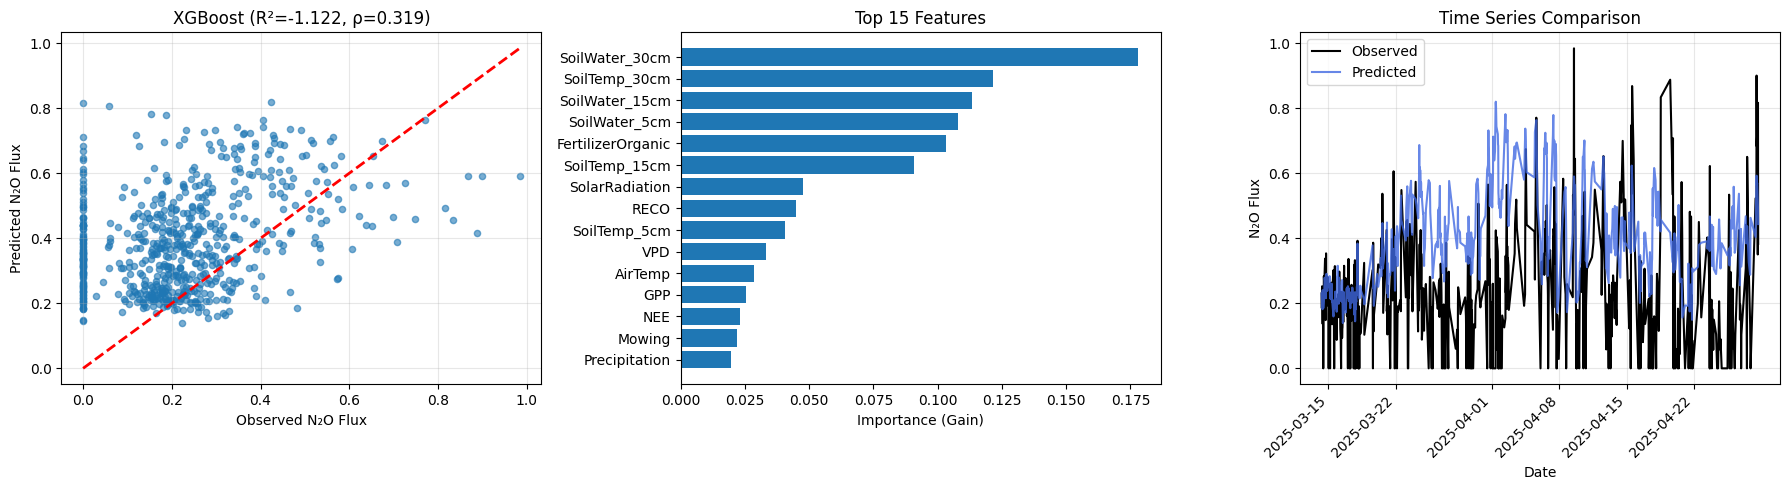


--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 2024-03-07 21:15:00 → 2025-02-17 21:15:00
Test  period: 2025-02-18 03:15:00 → 2025-05-03 13:15:00

Model evaluation:
  R² (linear scale): 0.144
  Spearman ρ:        0.451


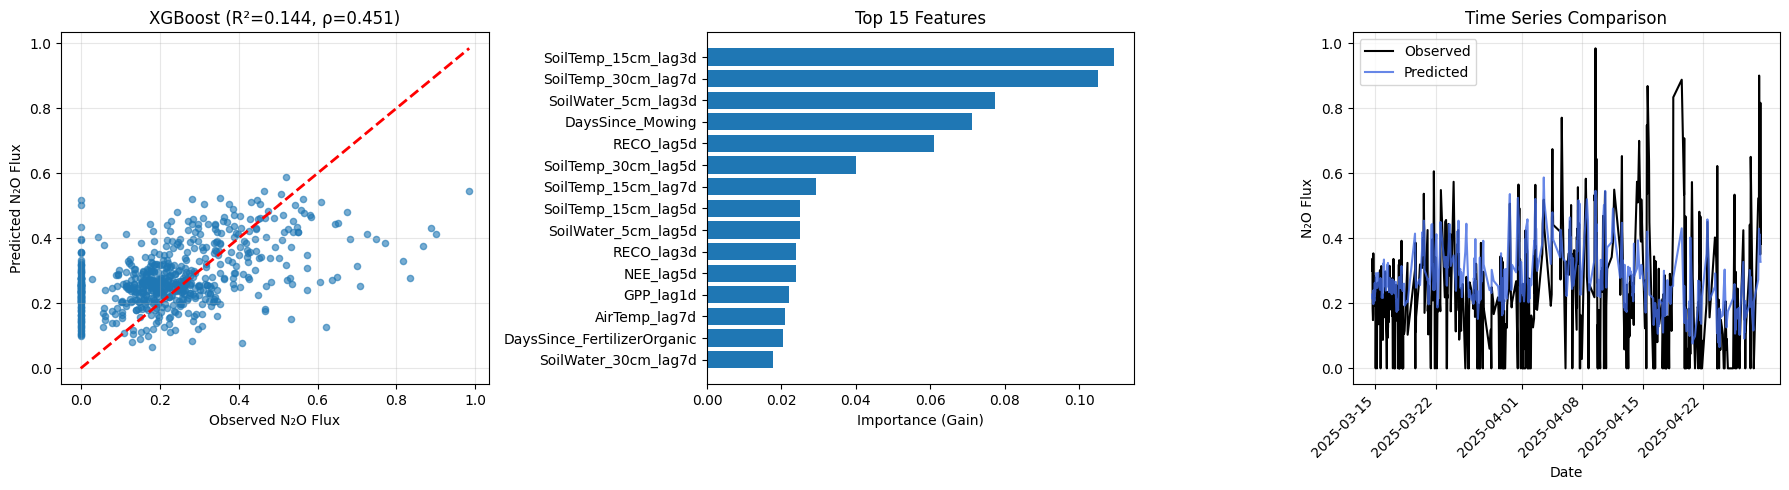


--- HOURLY | target=N2O_Flux_ln | predictors=AUGMENTED ---
Train period: 2024-03-07 21:15:00 → 2025-02-17 21:15:00
Test  period: 2025-02-18 03:15:00 → 2025-05-03 13:15:00

Model evaluation:
  R² (linear scale): 0.146
  Spearman ρ:        0.476


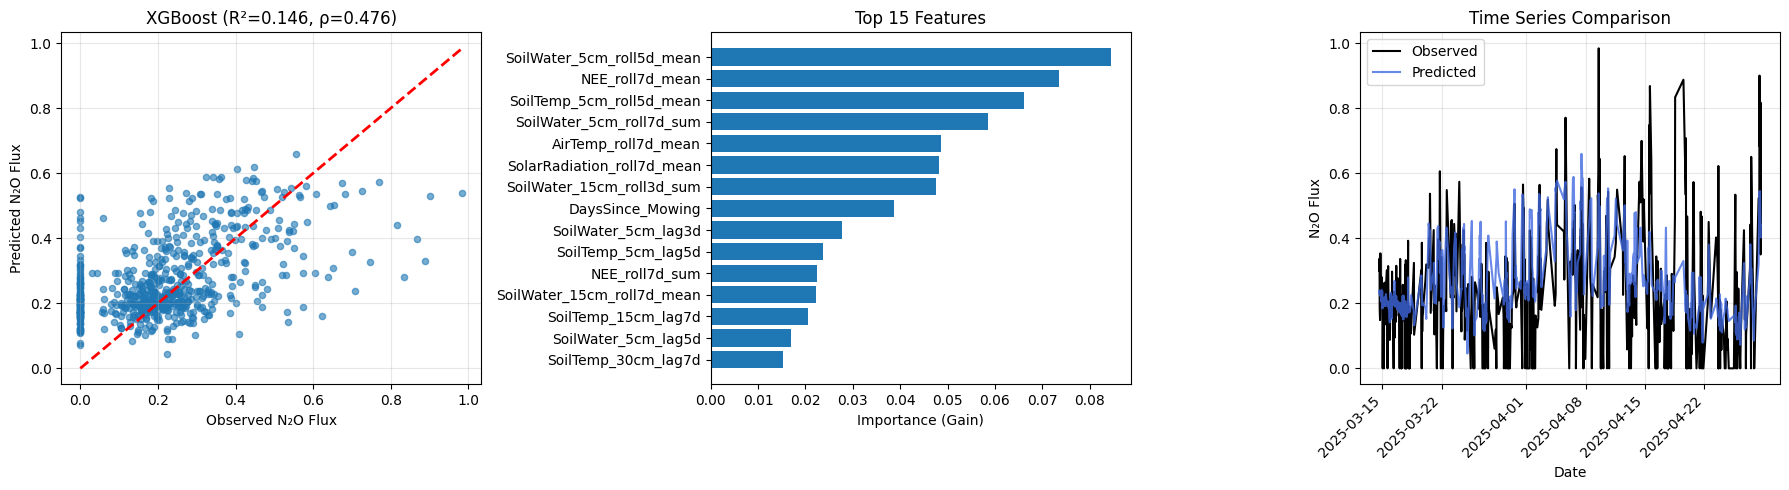


--- DAILY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 0 → 360
Test  period: 361 → 413

Model evaluation:
  R² (linear scale): -1.417
  Spearman ρ:        0.497


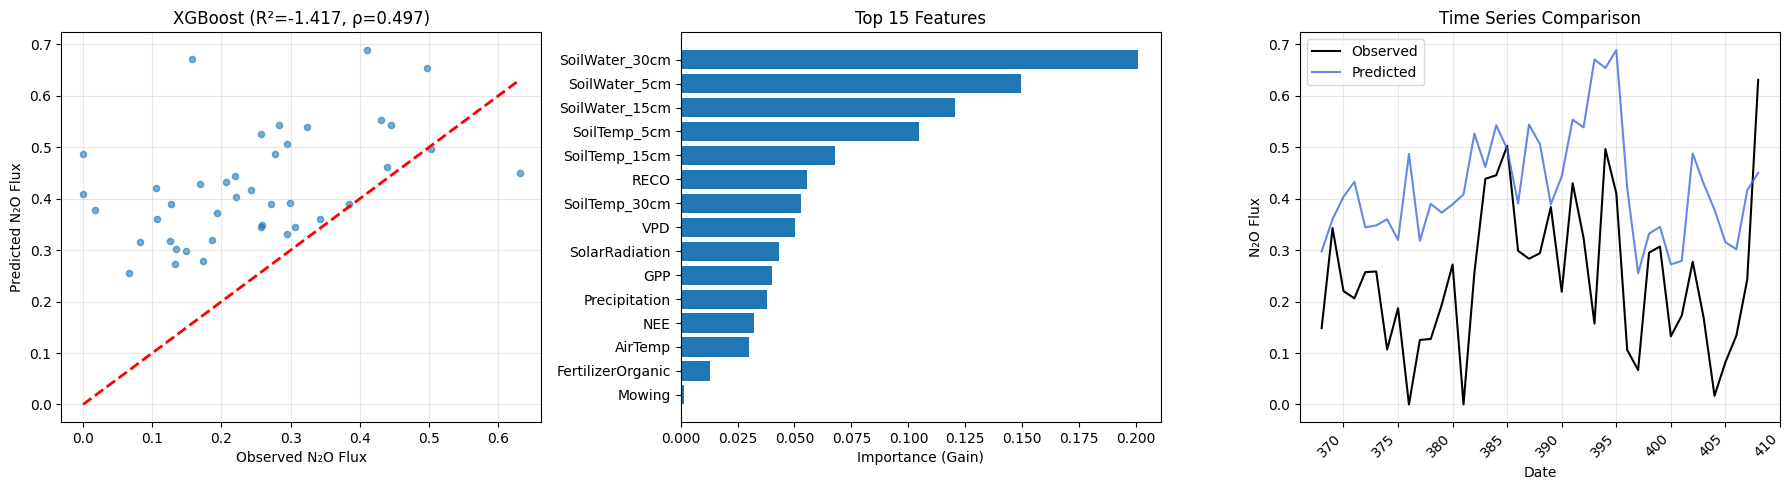


--- DAILY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 0 → 354
Test  period: 355 → 413

Model evaluation:
  R² (linear scale): -0.238
  Spearman ρ:        0.416


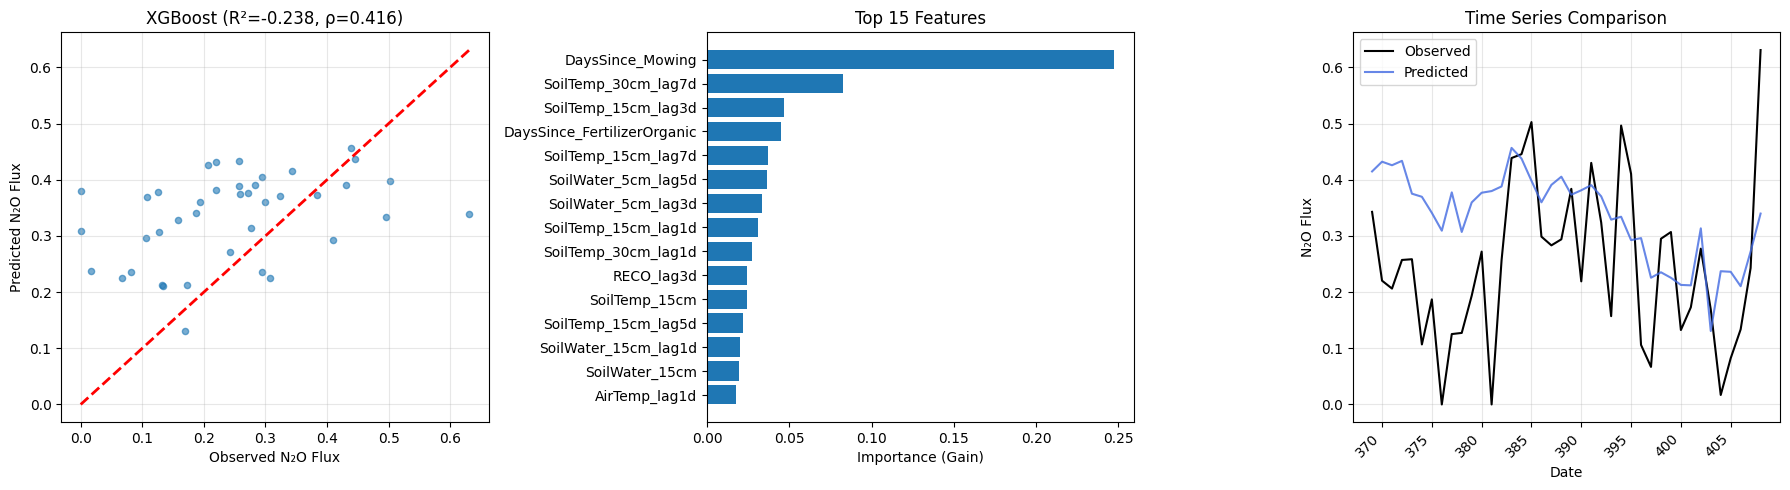


--- DAILY | target=N2O_Flux_ln | predictors=AUGMENTED ---
Train period: 0 → 354
Test  period: 355 → 413

Model evaluation:
  R² (linear scale): -0.292
  Spearman ρ:        0.510


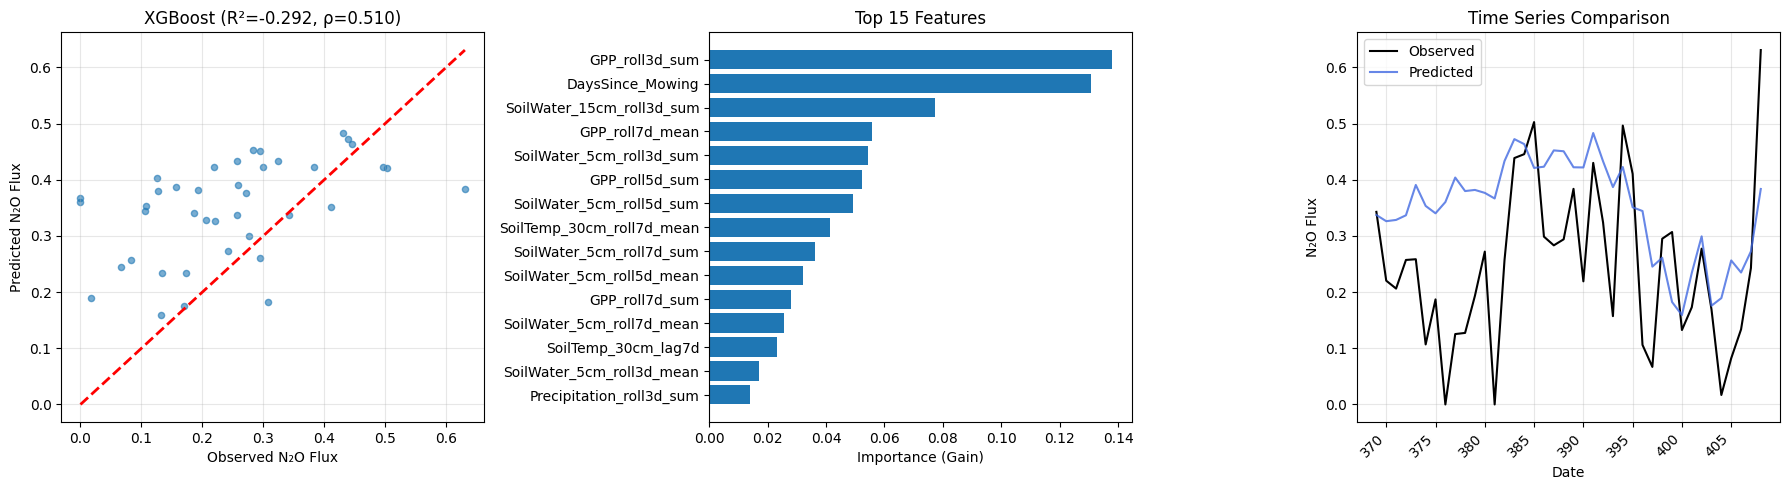


COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:
Temporal     Predictors   R²       Spearman ρ  
--------------------------------------------------------------------------------
Hourly       Base         -1.122        0.319
Hourly       Lag           0.144        0.451
Hourly       Augmented     0.146        0.476
Daily        Base         -1.417        0.497
Daily        Lag          -0.238        0.416
Daily        Augmented    -0.292        0.510

IMPROVEMENT FROM BASE TO LAG:
Hourly: R² +  1.266, ρ +  0.133
Daily:  R² +  1.179, ρ + -0.081

IMPROVEMENT FROM LAG TO AUGMENTED:
Hourly: R² +  0.001, ρ +  0.025
Daily:  R² + -0.053, ρ +  0.094


In [85]:
# ============================================================================
# FOREL
# ============================================================================

print("="*80)
print("EXPERIMENT 5: Forel 2024-2025")
print("="*80)

# Define base and lag predictors
base_predictors = [
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",
    "Mowing", "FertilizerOrganic", "FertilizerMineral",
]

lag_predictors = [
    # --- Meteorological base variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",

    # --- Meteorological lag variables ---
    "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
    "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
    "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
    "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
    "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
    "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
    "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
    "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
    "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
    "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
    "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
    "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
    "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",

    # --- Management variables ---
    "Mowing", "FertilizerOrganic", "FertilizerMineral",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
]

augmented_predictors = [
    # --- Base current-day variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",
    
    # --- Lag features (1, 3, 5, 7 days) ---
    "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
    "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
    "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
    "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
    "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
    "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
    "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
    "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
    "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
    "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
    "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
    "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
    "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
    
    # --- Rolling mean features (3, 5, 7 day windows) ---
    "NEE_roll3d_mean", "NEE_roll5d_mean", "NEE_roll7d_mean",
    "GPP_roll3d_mean", "GPP_roll5d_mean", "GPP_roll7d_mean",
    "RECO_roll3d_mean", "RECO_roll5d_mean", "RECO_roll7d_mean",
    "SolarRadiation_roll3d_mean", "SolarRadiation_roll5d_mean", "SolarRadiation_roll7d_mean",
    "AirTemp_roll3d_mean", "AirTemp_roll5d_mean", "AirTemp_roll7d_mean",
    "VPD_roll3d_mean", "VPD_roll5d_mean", "VPD_roll7d_mean",
    "SoilWater_5cm_roll3d_mean", "SoilWater_5cm_roll5d_mean", "SoilWater_5cm_roll7d_mean",
    "SoilWater_15cm_roll3d_mean", "SoilWater_15cm_roll5d_mean", "SoilWater_15cm_roll7d_mean",
    "SoilWater_30cm_roll3d_mean", "SoilWater_30cm_roll5d_mean", "SoilWater_30cm_roll7d_mean",
    "SoilTemp_5cm_roll3d_mean", "SoilTemp_5cm_roll5d_mean", "SoilTemp_5cm_roll7d_mean",
    "SoilTemp_15cm_roll3d_mean", "SoilTemp_15cm_roll5d_mean", "SoilTemp_15cm_roll7d_mean",
    "SoilTemp_30cm_roll3d_mean", "SoilTemp_30cm_roll5d_mean", "SoilTemp_30cm_roll7d_mean",
    "Precipitation_roll3d_mean", "Precipitation_roll5d_mean", "Precipitation_roll7d_mean",
    
    # --- Rolling sum features (3, 5, 7 day windows) ---
    "NEE_roll3d_sum", "NEE_roll5d_sum", "NEE_roll7d_sum",
    "GPP_roll3d_sum", "GPP_roll5d_sum", "GPP_roll7d_sum",
    "RECO_roll3d_sum", "RECO_roll5d_sum", "RECO_roll7d_sum",
    "SolarRadiation_roll3d_sum", "SolarRadiation_roll5d_sum", "SolarRadiation_roll7d_sum",
    "AirTemp_roll3d_sum", "AirTemp_roll5d_sum", "AirTemp_roll7d_sum",
    "VPD_roll3d_sum", "VPD_roll5d_sum", "VPD_roll7d_sum",
    "SoilWater_5cm_roll3d_sum", "SoilWater_5cm_roll5d_sum", "SoilWater_5cm_roll7d_sum",
    "SoilWater_15cm_roll3d_sum", "SoilWater_15cm_roll5d_sum", "SoilWater_15cm_roll7d_sum",
    "SoilWater_30cm_roll3d_sum", "SoilWater_30cm_roll5d_sum", "SoilWater_30cm_roll7d_sum",
    "SoilTemp_5cm_roll3d_sum", "SoilTemp_5cm_roll5d_sum", "SoilTemp_5cm_roll7d_sum",
    "SoilTemp_15cm_roll3d_sum", "SoilTemp_15cm_roll5d_sum", "SoilTemp_15cm_roll7d_sum",
    "SoilTemp_30cm_roll3d_sum", "SoilTemp_30cm_roll5d_sum", "SoilTemp_30cm_roll7d_sum",
    "Precipitation_roll3d_sum", "Precipitation_roll5d_sum", "Precipitation_roll7d_sum",
    
    # Management events and days since
    "Mowing", "FertilizerOrganic", "FertilizerMineral",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
]

# Store results for comparison
all_results = []

# ============================================================================
# HOURLY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_hourly_base = train_xgb_timeseries(
    df=forel_lag,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Base", results_hourly_base['r2'], results_hourly_base['spearman_rho']))


# ============================================================================
# HOURLY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_hourly_lag = train_xgb_timeseries(
    df=forel_lag,
    predictors=lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Lag", results_hourly_lag['r2'], results_hourly_lag['spearman_rho']))


# ============================================================================
# HOURLY DATA - AUGMENTED PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=AUGMENTED ---")
print("="*80)

results_hourly_augmented = train_xgb_timeseries(
    df=forel_lag,
    predictors=augmented_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Augmented", results_hourly_augmented['r2'], results_hourly_augmented['spearman_rho']))

# ============================================================================
# DAILY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_daily_base = train_xgb_timeseries(
    df=forel_daily,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Base", results_daily_base['r2'], results_daily_base['spearman_rho']))

# ============================================================================
# DAILY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_daily_lag = train_xgb_timeseries(
    df=forel_daily,
    predictors=lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Lag", results_daily_lag['r2'], results_daily_lag['spearman_rho']))


# ============================================================================
# DAILY DATA - AUGMENTED PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=AUGMENTED ---")
print("="*80)

results_daily_augmented = train_xgb_timeseries(
    df=forel_daily,
    predictors=augmented_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Augmented", results_daily_augmented['r2'], results_daily_augmented['spearman_rho']))

# ============================================================================
# COMPREHENSIVE COMPARISON
# ============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:")
print("="*80)
print(f"{'Temporal':<12} {'Predictors':<12} {'R²':<8} {'Spearman ρ':<12}")
print("-"*80)
for temp, pred, r2, rho in all_results:
    print(f"{temp:<12} {pred:<12} {r2:>6.3f}   {rho:>10.3f}")

print("\n" + "="*80)
print("IMPROVEMENT FROM BASE TO LAG:")
print("="*80)
print(f"Hourly: R² + {(results_hourly_lag['r2'] - results_hourly_base['r2']):>6.3f}, ρ + {(results_hourly_lag['spearman_rho'] - results_hourly_base['spearman_rho']):>6.3f}")
print(f"Daily:  R² + {(results_daily_lag['r2'] - results_daily_base['r2']):>6.3f}, ρ + {(results_daily_lag['spearman_rho'] - results_daily_base['spearman_rho']):>6.3f}")

print("\n" + "="*80)
print("IMPROVEMENT FROM LAG TO AUGMENTED:")
print("="*80)
print(f"Hourly: R² + {(results_hourly_augmented['r2'] - results_hourly_lag['r2']):>6.3f}, ρ + {(results_hourly_augmented['spearman_rho'] - results_hourly_lag['spearman_rho']):>6.3f}")
print(f"Daily:  R² + {(results_daily_augmented['r2'] - results_daily_lag['r2']):>6.3f}, ρ + {(results_daily_augmented['spearman_rho'] - results_daily_lag['spearman_rho']):>6.3f}")

# Experiment 6: Tanikon

In [78]:
# FIX TIMESTAMP
tanikon_lag['Timestamp'] = pd.to_datetime(tanikon_lag['Timestamp'])
tanikon_lag = tanikon_lag.set_index('Timestamp').sort_index()

tanikon_daily['Date'] = pd.to_datetime(tanikon_daily['Date'])
tanikon_daily = tanikon_daily.sort_values('Date')

# SPLIT BY PARCEL
tanikon_A = tanikon_lag[tanikon_lag['Parcel'] == 'A'].copy()
tanikon_B = tanikon_lag[tanikon_lag['Parcel'] == 'B'].copy()
tanikon_daily_A = tanikon_daily[tanikon_daily['Parcel'] == 'A'].set_index('Date')
tanikon_daily_B = tanikon_daily[tanikon_daily['Parcel'] == 'B'].set_index('Date')

In [79]:
def train_xgb_timeseries(df, predictors, target, test_size=0.1, n_estimators=300, random_state=42, plot=True):
    """
    Train XGBoost on time-series data using chronological split.
    
    Now includes a time series comparison plot showing observed vs predicted values over time.
    """
    # ENSURE TIME ORDER
    df = df.sort_index().copy()
    
    # EXTRACT FEATURES/TARGET
    X = df[predictors]
    y = df[target]
    
    # HANDLE NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X, y = X[mask], y[mask]
    
    # OFFSET FOR POSITIVITY
    offset = abs(y.min()) + 1e-6
    y_shifted = y + offset
    
    # CHRONOLOGICAL SPLIT
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y_shifted.iloc[:split_idx], y_shifted.iloc[split_idx:]
    
    # Store test dates for time series plot
    test_dates = X_test.index
    
    time_train = (df.index.min(), df.index[:split_idx].max())
    time_test = (df.index[split_idx], df.index.max())
    
    print(f"Train period: {time_train[0]} → {time_train[1]}")
    print(f"Test  period: {time_test[0]} → {time_test[1]}")
    
    # TRAIN MODEL
    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X_train, y_train, verbose=False)
    
    # PREDICTIONS
    y_pred = model.predict(X_test)
    
    # REVERT OFFSET
    y_pred_lin = y_pred - offset
    y_test_lin = y_test - offset
    
    # EVALUATION
    r2 = r2_score(y_test_lin, y_pred_lin)
    rho, _ = spearmanr(y_test_lin, y_pred_lin)
    
    # FEATURE IMPORTANCE
    importances = pd.Series(model.feature_importances_, index=predictors).sort_values(ascending=False)
    
    print("\nModel evaluation:")
    print(f"  R² (linear scale): {r2:.3f}")
    print(f"  Spearman ρ:        {rho:.3f}")
    
    # PLOT
    if plot:
        # Create 3-subplot figure: scatter, feature importance, and TIME SERIES
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))
        
        # 1. Scatter plot
        axes[0].scatter(y_test_lin, y_pred_lin, alpha=0.6, s=20)
        min_val, max_val = y_test_lin.min(), y_test_lin.max()
        axes[0].plot([min_val, max_val], [min_val, max_val], "r--", lw=2)
        axes[0].set_xlabel("Observed N₂O Flux")
        axes[0].set_ylabel("Predicted N₂O Flux")
        axes[0].set_title(f"XGBoost (R²={r2:.3f}, ρ={rho:.3f})")
        axes[0].grid(True, alpha=0.3)
        
        # 2. Feature importance
        top_features = importances.head(15)
        axes[1].barh(range(len(top_features)), top_features.values)
        axes[1].set_yticks(range(len(top_features)))
        axes[1].set_yticklabels(top_features.index)
        axes[1].set_xlabel("Importance (Gain)")
        axes[1].set_title("Top 15 Features")
        axes[1].invert_yaxis()
        
        # 3. TIME SERIES COMPARISON (NEW!)
        axes[2].plot(test_dates, y_test_lin.values, label="Observed", color="black", lw=1.5)
        axes[2].plot(test_dates, y_pred_lin, label="Predicted", color="royalblue", lw=1.5, alpha=0.8)
        axes[2].set_xlabel("Date")
        axes[2].set_ylabel("N₂O Flux")
        axes[2].set_title("Time Series Comparison")
        axes[2].legend()
        axes[2].grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.setp(axes[2].xaxis.get_majorticklabels(), rotation=45, ha='right')
        
        plt.tight_layout()
        plt.show()
    
    return {
        "model": model,
        "r2": r2,
        "spearman_rho": rho,
        "feature_importance": importances,
        "y_test": y_test_lin,
        "y_pred": y_pred_lin,
        "test_dates": test_dates,  # Also return test dates
    }

EXPERIMENT 6: Tanikon 2023-2025

--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 2023-11-07 15:45:00 → 2025-02-17 03:45:00
Test  period: 2025-02-17 04:15:00 → 2025-06-05 00:45:00

Model evaluation:
  R² (linear scale): -65.989
  Spearman ρ:        0.054


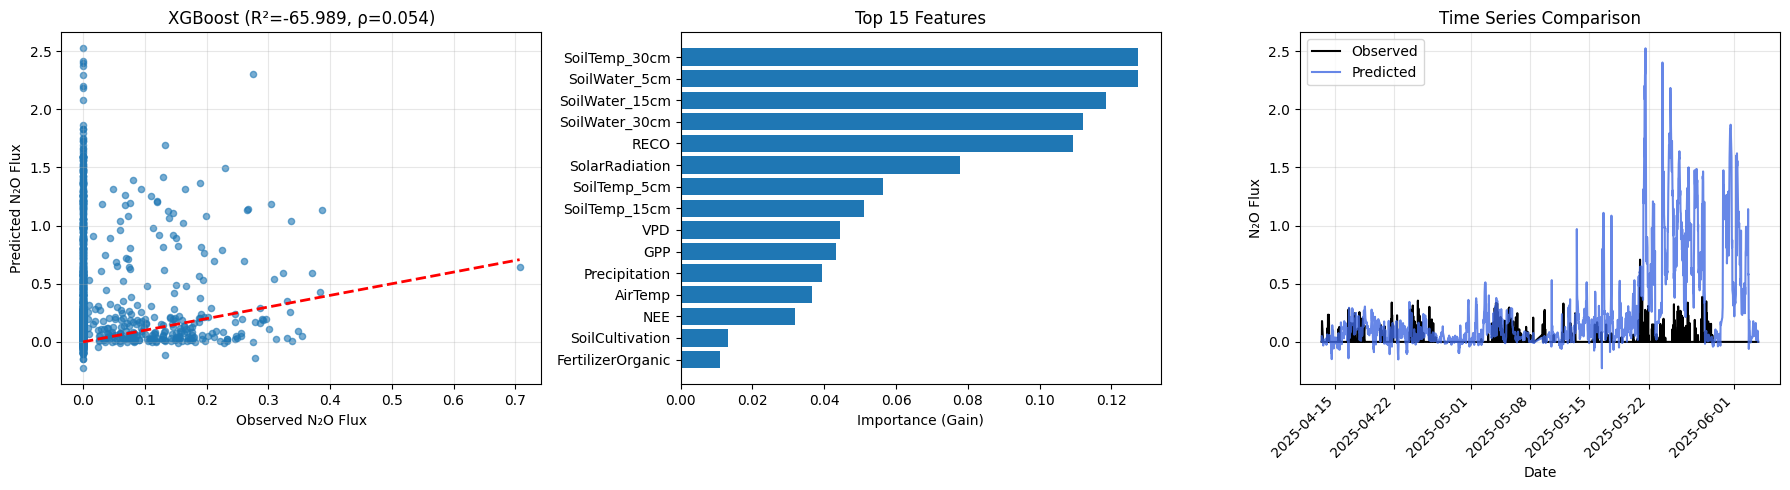


--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 2023-11-07 15:45:00 → 2025-01-30 12:15:00
Test  period: 2025-01-30 12:45:00 → 2025-06-05 00:45:00

Model evaluation:
  R² (linear scale): -35.941
  Spearman ρ:        0.139


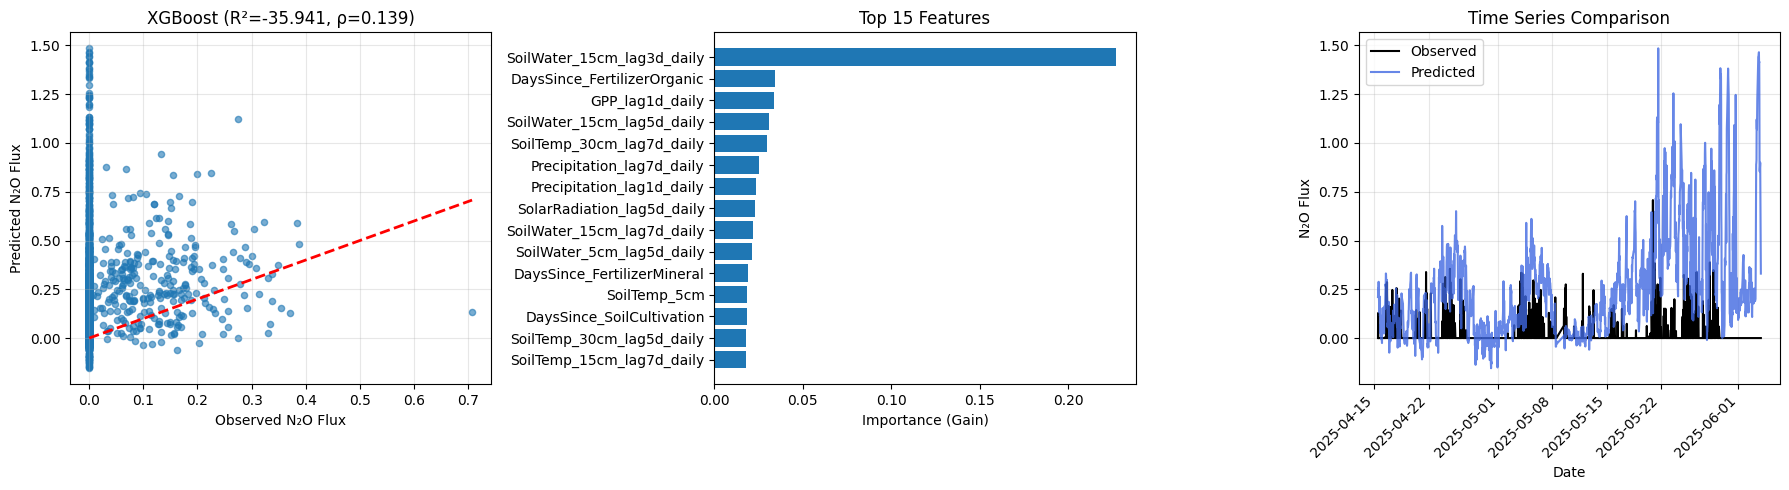


--- HOURLY | target=N2O_Flux_ln | predictors=AUGMENTED ---
Train period: 2023-11-07 15:45:00 → 2025-01-30 12:15:00
Test  period: 2025-01-30 12:45:00 → 2025-06-05 00:45:00

Model evaluation:
  R² (linear scale): -56.267
  Spearman ρ:        0.173


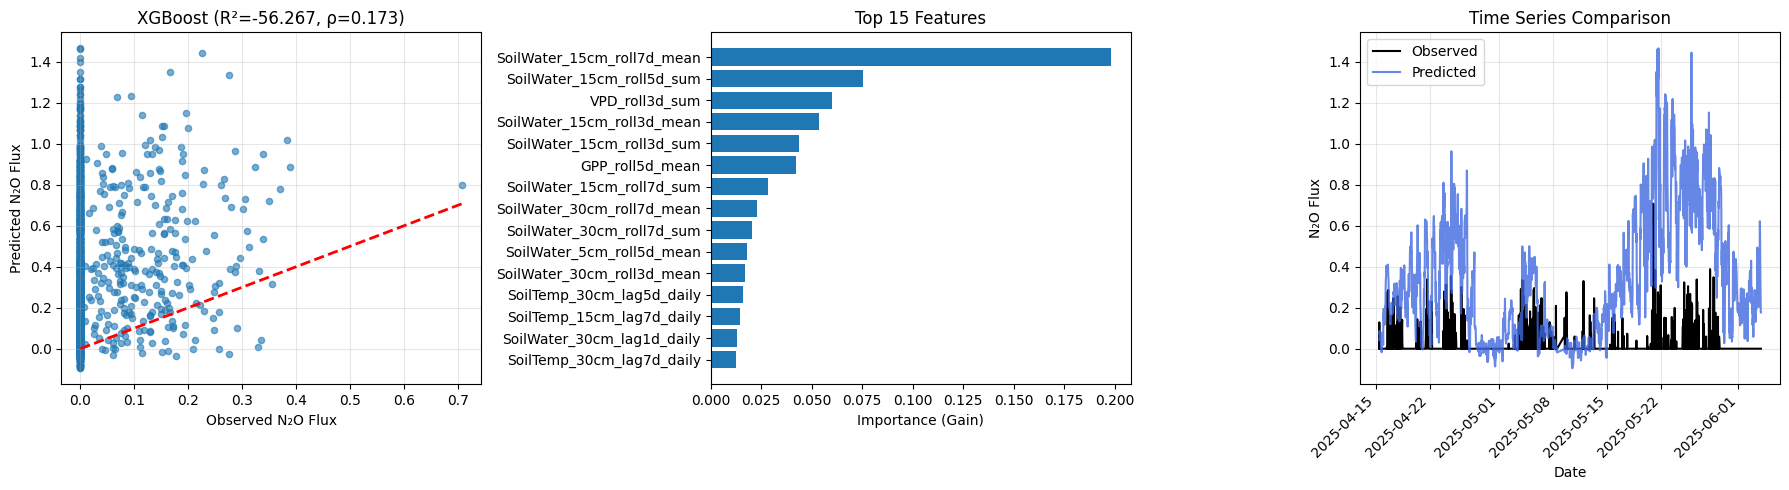


--- DAILY | target=N2O_Flux_ln | predictors=BASE ---
Train period: 0 → 717
Test  period: 718 → 877

Model evaluation:
  R² (linear scale): -3.127
  Spearman ρ:        0.147


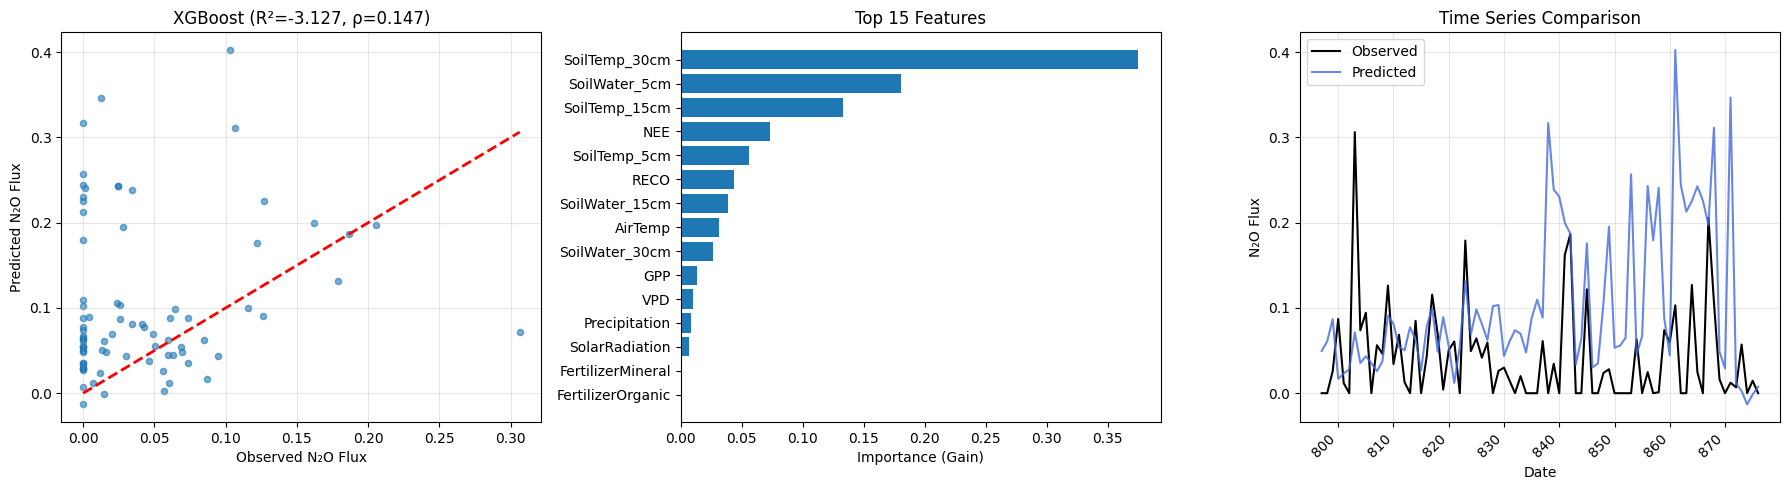


--- DAILY | target=N2O_Flux_ln | predictors=LAG ---
Train period: 0 → 691
Test  period: 692 → 877

Model evaluation:
  R² (linear scale): -4.564
  Spearman ρ:        -0.052


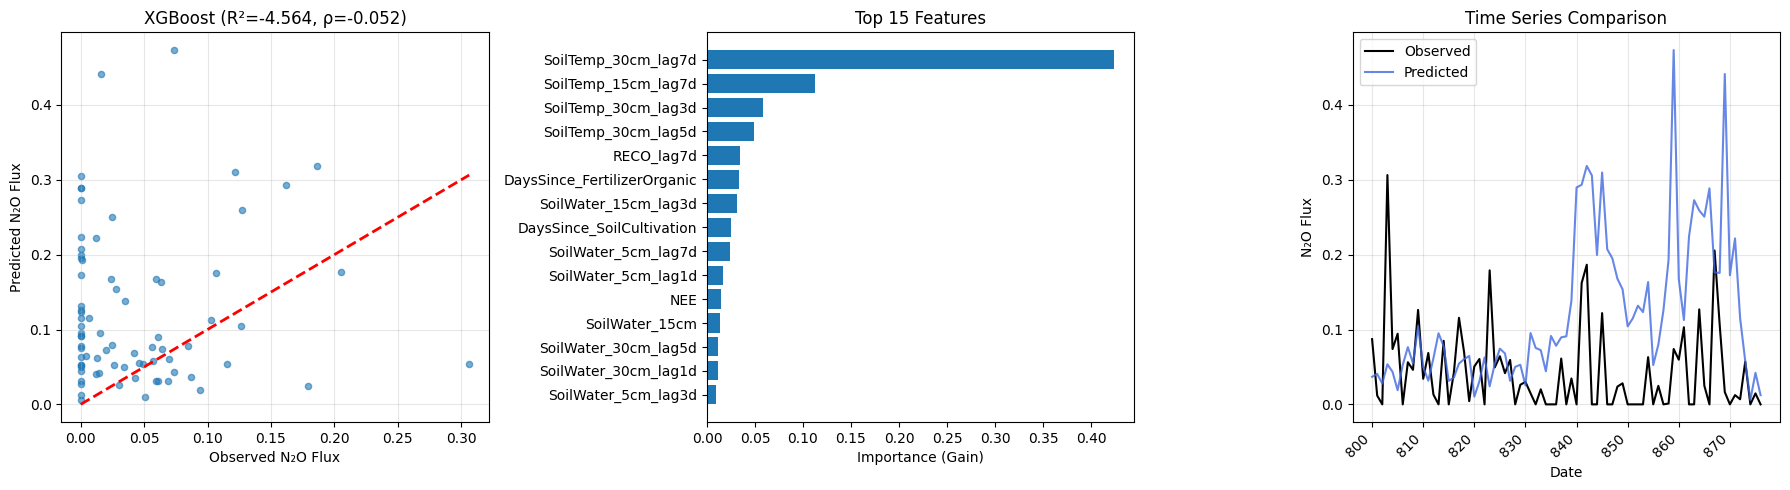


--- DAILY | target=N2O_Flux_ln | predictors=AUGMENTED ---
Train period: 0 → 691
Test  period: 692 → 877

Model evaluation:
  R² (linear scale): -8.801
  Spearman ρ:        -0.016


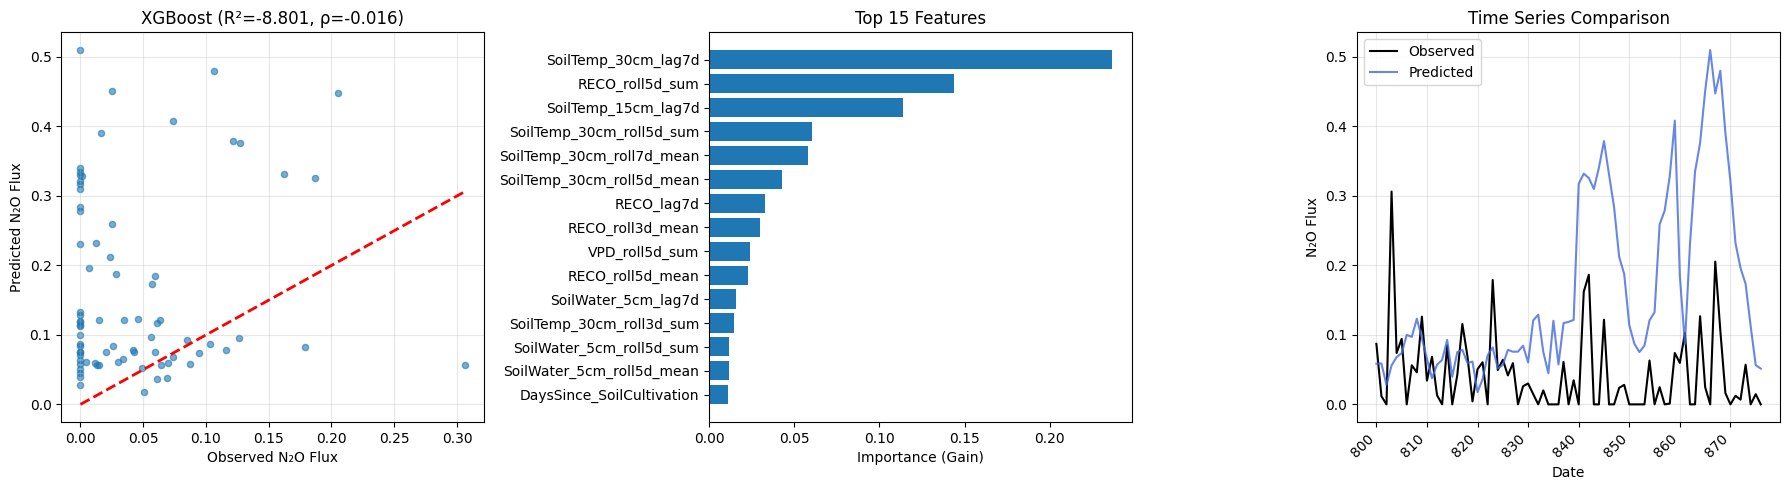


COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:
Temporal     Predictors   R²       Spearman ρ  
--------------------------------------------------------------------------------
Hourly       Base         -65.989        0.054
Hourly       Lag          -35.941        0.139
Hourly       Augmented    -56.267        0.173
Daily        Base         -3.127        0.147
Daily        Lag          -4.564       -0.052
Daily        Augmented    -8.801       -0.016

IMPROVEMENT FROM BASE TO LAG:
Hourly: R² + 30.048, ρ +  0.085
Daily:  R² + -1.437, ρ + -0.199

IMPROVEMENT FROM LAG TO AUGMENTED:
Hourly: R² + -20.326, ρ +  0.034
Daily:  R² + -4.236, ρ +  0.036


In [80]:
# ============================================================================
# TANIKON
# ============================================================================

print("="*80)
print("EXPERIMENT 6: Tanikon 2023-2025")
print("="*80)

# Define base and lag predictors
base_predictors = [
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
]

hourly_lag_predictors = [
    # --- Meteorological base variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",

    # --- Meteorological lag variables ---
    "NEE_lag1d_daily", "NEE_lag3d_daily", "NEE_lag5d_daily", "NEE_lag7d_daily",
    "GPP_lag1d_daily", "GPP_lag3d_daily", "GPP_lag5d_daily", "GPP_lag7d_daily",
    "RECO_lag1d_daily", "RECO_lag3d_daily", "RECO_lag5d_daily", "RECO_lag7d_daily",
    "SolarRadiation_lag1d_daily", "SolarRadiation_lag3d_daily", "SolarRadiation_lag5d_daily", "SolarRadiation_lag7d_daily",
    "AirTemp_lag1d_daily", "AirTemp_lag3d_daily", "AirTemp_lag5d_daily", "AirTemp_lag7d_daily",
    "VPD_lag1d_daily", "VPD_lag3d_daily", "VPD_lag5d_daily", "VPD_lag7d_daily",
    "SoilWater_5cm_lag1d_daily", "SoilWater_5cm_lag3d_daily", "SoilWater_5cm_lag5d_daily", "SoilWater_5cm_lag7d_daily",
    "SoilWater_15cm_lag1d_daily", "SoilWater_15cm_lag3d_daily", "SoilWater_15cm_lag5d_daily", "SoilWater_15cm_lag7d_daily",
    "SoilWater_30cm_lag1d_daily", "SoilWater_30cm_lag3d_daily", "SoilWater_30cm_lag5d_daily", "SoilWater_30cm_lag7d_daily",
    "SoilTemp_5cm_lag1d_daily", "SoilTemp_5cm_lag3d_daily", "SoilTemp_5cm_lag5d_daily", "SoilTemp_5cm_lag7d_daily",
    "SoilTemp_15cm_lag1d_daily", "SoilTemp_15cm_lag3d_daily", "SoilTemp_15cm_lag5d_daily", "SoilTemp_15cm_lag7d_daily",
    "SoilTemp_30cm_lag1d_daily", "SoilTemp_30cm_lag3d_daily", "SoilTemp_30cm_lag5d_daily", "SoilTemp_30cm_lag7d_daily",
    "Precipitation_lag1d_daily", "Precipitation_lag3d_daily", "Precipitation_lag5d_daily", "Precipitation_lag7d_daily",

    # --- Management variables ---
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_SoilCultivation"
]

hourly_augmented_predictors = [
    # --- Base current-day variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",
    
    # --- Lag features (1, 3, 5, 7 days) ---
    "NEE_lag1d_daily", "NEE_lag3d_daily", "NEE_lag5d_daily", "NEE_lag7d_daily",
    "GPP_lag1d_daily", "GPP_lag3d_daily", "GPP_lag5d_daily", "GPP_lag7d_daily",
    "RECO_lag1d_daily", "RECO_lag3d_daily", "RECO_lag5d_daily", "RECO_lag7d_daily",
    "SolarRadiation_lag1d_daily", "SolarRadiation_lag3d_daily", "SolarRadiation_lag5d_daily", "SolarRadiation_lag7d_daily",
    "AirTemp_lag1d_daily", "AirTemp_lag3d_daily", "AirTemp_lag5d_daily", "AirTemp_lag7d_daily",
    "VPD_lag1d_daily", "VPD_lag3d_daily", "VPD_lag5d_daily", "VPD_lag7d_daily",
    "SoilWater_5cm_lag1d_daily", "SoilWater_5cm_lag3d_daily", "SoilWater_5cm_lag5d_daily", "SoilWater_5cm_lag7d_daily",
    "SoilWater_15cm_lag1d_daily", "SoilWater_15cm_lag3d_daily", "SoilWater_15cm_lag5d_daily", "SoilWater_15cm_lag7d_daily",
    "SoilWater_30cm_lag1d_daily", "SoilWater_30cm_lag3d_daily", "SoilWater_30cm_lag5d_daily", "SoilWater_30cm_lag7d_daily",
    "SoilTemp_5cm_lag1d_daily", "SoilTemp_5cm_lag3d_daily", "SoilTemp_5cm_lag5d_daily", "SoilTemp_5cm_lag7d_daily",
    "SoilTemp_15cm_lag1d_daily", "SoilTemp_15cm_lag3d_daily", "SoilTemp_15cm_lag5d_daily", "SoilTemp_15cm_lag7d_daily",
    "SoilTemp_30cm_lag1d_daily", "SoilTemp_30cm_lag3d_daily", "SoilTemp_30cm_lag5d_daily", "SoilTemp_30cm_lag7d_daily",
    "Precipitation_lag1d_daily", "Precipitation_lag3d_daily", "Precipitation_lag5d_daily", "Precipitation_lag7d_daily",
    
    # --- Rolling mean features (3, 5, 7 day windows) ---
    "NEE_roll3d_mean", "NEE_roll5d_mean", "NEE_roll7d_mean",
    "GPP_roll3d_mean", "GPP_roll5d_mean", "GPP_roll7d_mean",
    "RECO_roll3d_mean", "RECO_roll5d_mean", "RECO_roll7d_mean",
    "SolarRadiation_roll3d_mean", "SolarRadiation_roll5d_mean", "SolarRadiation_roll7d_mean",
    "AirTemp_roll3d_mean", "AirTemp_roll5d_mean", "AirTemp_roll7d_mean",
    "VPD_roll3d_mean", "VPD_roll5d_mean", "VPD_roll7d_mean",
    "SoilWater_5cm_roll3d_mean", "SoilWater_5cm_roll5d_mean", "SoilWater_5cm_roll7d_mean",
    "SoilWater_15cm_roll3d_mean", "SoilWater_15cm_roll5d_mean", "SoilWater_15cm_roll7d_mean",
    "SoilWater_30cm_roll3d_mean", "SoilWater_30cm_roll5d_mean", "SoilWater_30cm_roll7d_mean",
    "SoilTemp_5cm_roll3d_mean", "SoilTemp_5cm_roll5d_mean", "SoilTemp_5cm_roll7d_mean",
    "SoilTemp_15cm_roll3d_mean", "SoilTemp_15cm_roll5d_mean", "SoilTemp_15cm_roll7d_mean",
    "SoilTemp_30cm_roll3d_mean", "SoilTemp_30cm_roll5d_mean", "SoilTemp_30cm_roll7d_mean",
    "Precipitation_roll3d_mean", "Precipitation_roll5d_mean", "Precipitation_roll7d_mean",
    
    # --- Rolling sum features (3, 5, 7 day windows) ---
    "NEE_roll3d_sum", "NEE_roll5d_sum", "NEE_roll7d_sum",
    "GPP_roll3d_sum", "GPP_roll5d_sum", "GPP_roll7d_sum",
    "RECO_roll3d_sum", "RECO_roll5d_sum", "RECO_roll7d_sum",
    "SolarRadiation_roll3d_sum", "SolarRadiation_roll5d_sum", "SolarRadiation_roll7d_sum",
    "AirTemp_roll3d_sum", "AirTemp_roll5d_sum", "AirTemp_roll7d_sum",
    "VPD_roll3d_sum", "VPD_roll5d_sum", "VPD_roll7d_sum",
    "SoilWater_5cm_roll3d_sum", "SoilWater_5cm_roll5d_sum", "SoilWater_5cm_roll7d_sum",
    "SoilWater_15cm_roll3d_sum", "SoilWater_15cm_roll5d_sum", "SoilWater_15cm_roll7d_sum",
    "SoilWater_30cm_roll3d_sum", "SoilWater_30cm_roll5d_sum", "SoilWater_30cm_roll7d_sum",
    "SoilTemp_5cm_roll3d_sum", "SoilTemp_5cm_roll5d_sum", "SoilTemp_5cm_roll7d_sum",
    "SoilTemp_15cm_roll3d_sum", "SoilTemp_15cm_roll5d_sum", "SoilTemp_15cm_roll7d_sum",
    "SoilTemp_30cm_roll3d_sum", "SoilTemp_30cm_roll5d_sum", "SoilTemp_30cm_roll7d_sum",
    "Precipitation_roll3d_sum", "Precipitation_roll5d_sum", "Precipitation_roll7d_sum",
    
    # Management events and days since
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_SoilCultivation"
]

daily_lag_predictors = [
    # --- Meteorological base variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",

    # --- Meteorological lag variables ---
    "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
    "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
    "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
    "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
    "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
    "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
    "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
    "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
    "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
    "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
    "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
    "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
    "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",

    # --- Management variables ---
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_SoilCultivation"
]

daily_augmented_predictors = [
    # --- Base current-day variables ---
    "Precipitation", "SolarRadiation", "AirTemp", "VPD",
    "SoilWater_5cm", "SoilWater_15cm", "SoilWater_30cm", "SoilTemp_5cm", "SoilTemp_15cm", "SoilTemp_30cm",
    "NEE", "GPP", "RECO",
    
    # --- Lag features (1, 3, 5, 7 days) ---
    "NEE_lag1d", "NEE_lag3d", "NEE_lag5d", "NEE_lag7d",
    "GPP_lag1d", "GPP_lag3d", "GPP_lag5d", "GPP_lag7d",
    "RECO_lag1d", "RECO_lag3d", "RECO_lag5d", "RECO_lag7d",
    "SolarRadiation_lag1d", "SolarRadiation_lag3d", "SolarRadiation_lag5d", "SolarRadiation_lag7d",
    "AirTemp_lag1d", "AirTemp_lag3d", "AirTemp_lag5d", "AirTemp_lag7d",
    "VPD_lag1d", "VPD_lag3d", "VPD_lag5d", "VPD_lag7d",
    "SoilWater_5cm_lag1d", "SoilWater_5cm_lag3d", "SoilWater_5cm_lag5d", "SoilWater_5cm_lag7d",
    "SoilWater_15cm_lag1d", "SoilWater_15cm_lag3d", "SoilWater_15cm_lag5d", "SoilWater_15cm_lag7d",
    "SoilWater_30cm_lag1d", "SoilWater_30cm_lag3d", "SoilWater_30cm_lag5d", "SoilWater_30cm_lag7d",
    "SoilTemp_5cm_lag1d", "SoilTemp_5cm_lag3d", "SoilTemp_5cm_lag5d", "SoilTemp_5cm_lag7d",
    "SoilTemp_15cm_lag1d", "SoilTemp_15cm_lag3d", "SoilTemp_15cm_lag5d", "SoilTemp_15cm_lag7d",
    "SoilTemp_30cm_lag1d", "SoilTemp_30cm_lag3d", "SoilTemp_30cm_lag5d", "SoilTemp_30cm_lag7d",
    "Precipitation_lag1d", "Precipitation_lag3d", "Precipitation_lag5d", "Precipitation_lag7d",
    
    # --- Rolling mean features (3, 5, 7 day windows) ---
    "NEE_roll3d_mean", "NEE_roll5d_mean", "NEE_roll7d_mean",
    "GPP_roll3d_mean", "GPP_roll5d_mean", "GPP_roll7d_mean",
    "RECO_roll3d_mean", "RECO_roll5d_mean", "RECO_roll7d_mean",
    "SolarRadiation_roll3d_mean", "SolarRadiation_roll5d_mean", "SolarRadiation_roll7d_mean",
    "AirTemp_roll3d_mean", "AirTemp_roll5d_mean", "AirTemp_roll7d_mean",
    "VPD_roll3d_mean", "VPD_roll5d_mean", "VPD_roll7d_mean",
    "SoilWater_5cm_roll3d_mean", "SoilWater_5cm_roll5d_mean", "SoilWater_5cm_roll7d_mean",
    "SoilWater_15cm_roll3d_mean", "SoilWater_15cm_roll5d_mean", "SoilWater_15cm_roll7d_mean",
    "SoilWater_30cm_roll3d_mean", "SoilWater_30cm_roll5d_mean", "SoilWater_30cm_roll7d_mean",
    "SoilTemp_5cm_roll3d_mean", "SoilTemp_5cm_roll5d_mean", "SoilTemp_5cm_roll7d_mean",
    "SoilTemp_15cm_roll3d_mean", "SoilTemp_15cm_roll5d_mean", "SoilTemp_15cm_roll7d_mean",
    "SoilTemp_30cm_roll3d_mean", "SoilTemp_30cm_roll5d_mean", "SoilTemp_30cm_roll7d_mean",
    "Precipitation_roll3d_mean", "Precipitation_roll5d_mean", "Precipitation_roll7d_mean",
    
    # --- Rolling sum features (3, 5, 7 day windows) ---
    "NEE_roll3d_sum", "NEE_roll5d_sum", "NEE_roll7d_sum",
    "GPP_roll3d_sum", "GPP_roll5d_sum", "GPP_roll7d_sum",
    "RECO_roll3d_sum", "RECO_roll5d_sum", "RECO_roll7d_sum",
    "SolarRadiation_roll3d_sum", "SolarRadiation_roll5d_sum", "SolarRadiation_roll7d_sum",
    "AirTemp_roll3d_sum", "AirTemp_roll5d_sum", "AirTemp_roll7d_sum",
    "VPD_roll3d_sum", "VPD_roll5d_sum", "VPD_roll7d_sum",
    "SoilWater_5cm_roll3d_sum", "SoilWater_5cm_roll5d_sum", "SoilWater_5cm_roll7d_sum",
    "SoilWater_15cm_roll3d_sum", "SoilWater_15cm_roll5d_sum", "SoilWater_15cm_roll7d_sum",
    "SoilWater_30cm_roll3d_sum", "SoilWater_30cm_roll5d_sum", "SoilWater_30cm_roll7d_sum",
    "SoilTemp_5cm_roll3d_sum", "SoilTemp_5cm_roll5d_sum", "SoilTemp_5cm_roll7d_sum",
    "SoilTemp_15cm_roll3d_sum", "SoilTemp_15cm_roll5d_sum", "SoilTemp_15cm_roll7d_sum",
    "SoilTemp_30cm_roll3d_sum", "SoilTemp_30cm_roll5d_sum", "SoilTemp_30cm_roll7d_sum",
    "Precipitation_roll3d_sum", "Precipitation_roll5d_sum", "Precipitation_roll7d_sum",
    
    # Management events and days since
    "Mowing", "FertilizerOrganic", "FertilizerMineral", "SoilCultivation",
    "DaysSince_Mowing", "DaysSince_FertilizerOrganic", "DaysSince_FertilizerMineral",
    "DaysSince_SoilCultivation"
]

# Store results for comparison
all_results = []

# ============================================================================
# HOURLY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_hourly_base = train_xgb_timeseries(
    df=tanikon_lag,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Base", results_hourly_base['r2'], results_hourly_base['spearman_rho']))


# ============================================================================
# HOURLY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_hourly_lag = train_xgb_timeseries(
    df=tanikon_lag,
    predictors=hourly_lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Lag", results_hourly_lag['r2'], results_hourly_lag['spearman_rho']))


# ============================================================================
# HOURLY DATA - AUGMENTED PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- HOURLY | target=N2O_Flux_ln | predictors=AUGMENTED ---")
print("="*80)

results_hourly_augmented = train_xgb_timeseries(
    df=tanikon_lag,
    predictors=hourly_augmented_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Hourly", "Augmented", results_hourly_augmented['r2'], results_hourly_augmented['spearman_rho']))

# ============================================================================
# DAILY DATA - BASE PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=BASE ---")
print("="*80)

results_daily_base = train_xgb_timeseries(
    df=tanikon_daily,
    predictors=base_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Base", results_daily_base['r2'], results_daily_base['spearman_rho']))

# ============================================================================
# DAILY DATA - LAG PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=LAG ---")
print("="*80)

results_daily_lag = train_xgb_timeseries(
    df=tanikon_daily,
    predictors=daily_lag_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Lag", results_daily_lag['r2'], results_daily_lag['spearman_rho']))


# ============================================================================
# DAILY DATA - AUGMENTED PREDICTORS
# ============================================================================
print("\n" + "="*80)
print("--- DAILY | target=N2O_Flux_ln | predictors=AUGMENTED ---")
print("="*80)

results_daily_augmented = train_xgb_timeseries(
    df=tanikon_daily,
    predictors=daily_augmented_predictors,
    target="N2O_Flux_ln",
    plot=True
)
all_results.append(("Daily", "Augmented", results_daily_augmented['r2'], results_daily_augmented['spearman_rho']))

# ============================================================================
# COMPREHENSIVE COMPARISON
# ============================================================================
print("\n" + "="*80)
print("COMPREHENSIVE COMPARISON OF ALL EXPERIMENTS:")
print("="*80)
print(f"{'Temporal':<12} {'Predictors':<12} {'R²':<8} {'Spearman ρ':<12}")
print("-"*80)
for temp, pred, r2, rho in all_results:
    print(f"{temp:<12} {pred:<12} {r2:>6.3f}   {rho:>10.3f}")

print("\n" + "="*80)
print("IMPROVEMENT FROM BASE TO LAG:")
print("="*80)
print(f"Hourly: R² + {(results_hourly_lag['r2'] - results_hourly_base['r2']):>6.3f}, ρ + {(results_hourly_lag['spearman_rho'] - results_hourly_base['spearman_rho']):>6.3f}")
print(f"Daily:  R² + {(results_daily_lag['r2'] - results_daily_base['r2']):>6.3f}, ρ + {(results_daily_lag['spearman_rho'] - results_daily_base['spearman_rho']):>6.3f}")

print("\n" + "="*80)
print("IMPROVEMENT FROM LAG TO AUGMENTED:")
print("="*80)
print(f"Hourly: R² + {(results_hourly_augmented['r2'] - results_hourly_lag['r2']):>6.3f}, ρ + {(results_hourly_augmented['spearman_rho'] - results_hourly_lag['spearman_rho']):>6.3f}")
print(f"Daily:  R² + {(results_daily_augmented['r2'] - results_daily_lag['r2']):>6.3f}, ρ + {(results_daily_augmented['spearman_rho'] - results_daily_lag['spearman_rho']):>6.3f}")